/tmp/ipykernel_4765/175665538.py:34: PydanticDeprecatedSince20: Pydantic V1 style `@validator` validators are deprecated. You should migrate to Pydantic V2 style `@field_validator` validators, see the migration guide for more details. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.7/migration/
  @validator("color_im")
/tmp/ipykernel_4765/175665538.py:41: PydanticDeprecatedSince20: Pydantic V1 style `@validator` validators are deprecated. You should migrate to Pydantic V2 style `@field_validator` validators, see the migration guide for more details. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.7/migration/
  @validator("depth_im")
/tmp/ipykernel_4765/175665538.py:48: PydanticDeprecatedSince20: Pydantic V1 style `@validator` validators are deprecated. You should migrate to Pydantic V2 style `@field_validator` validators, see the migration guide for m

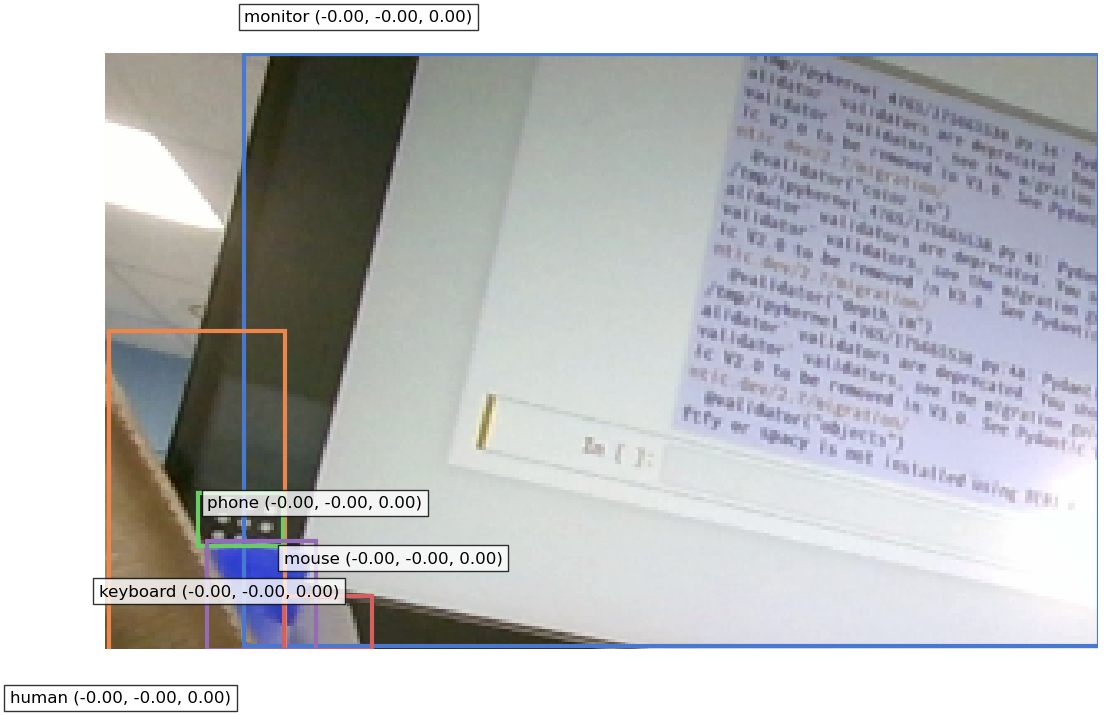

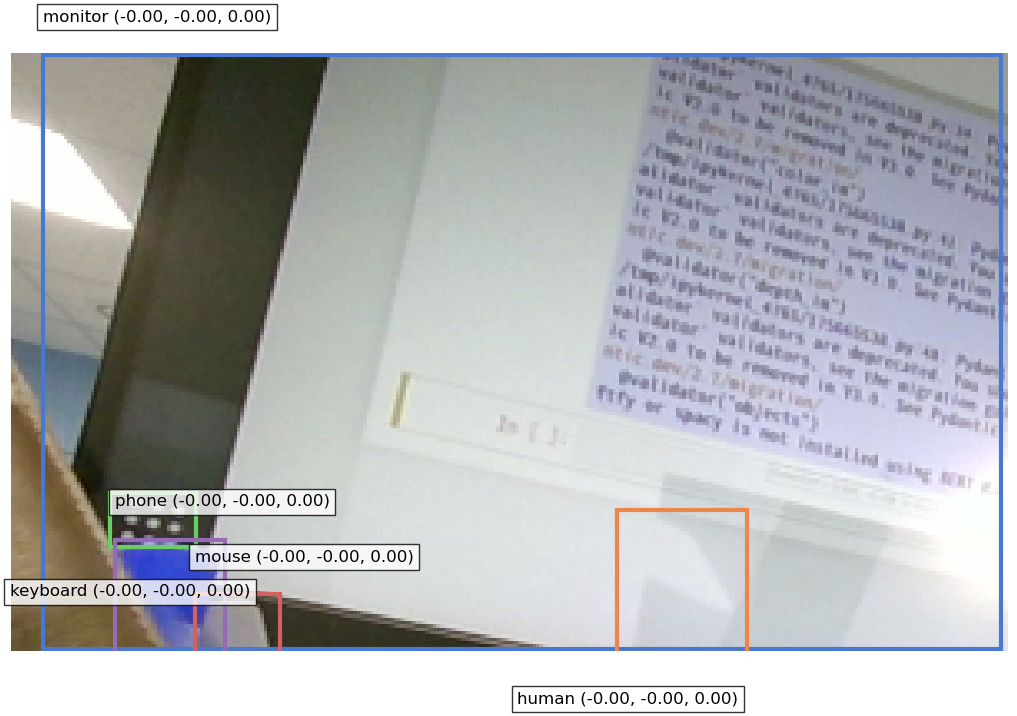

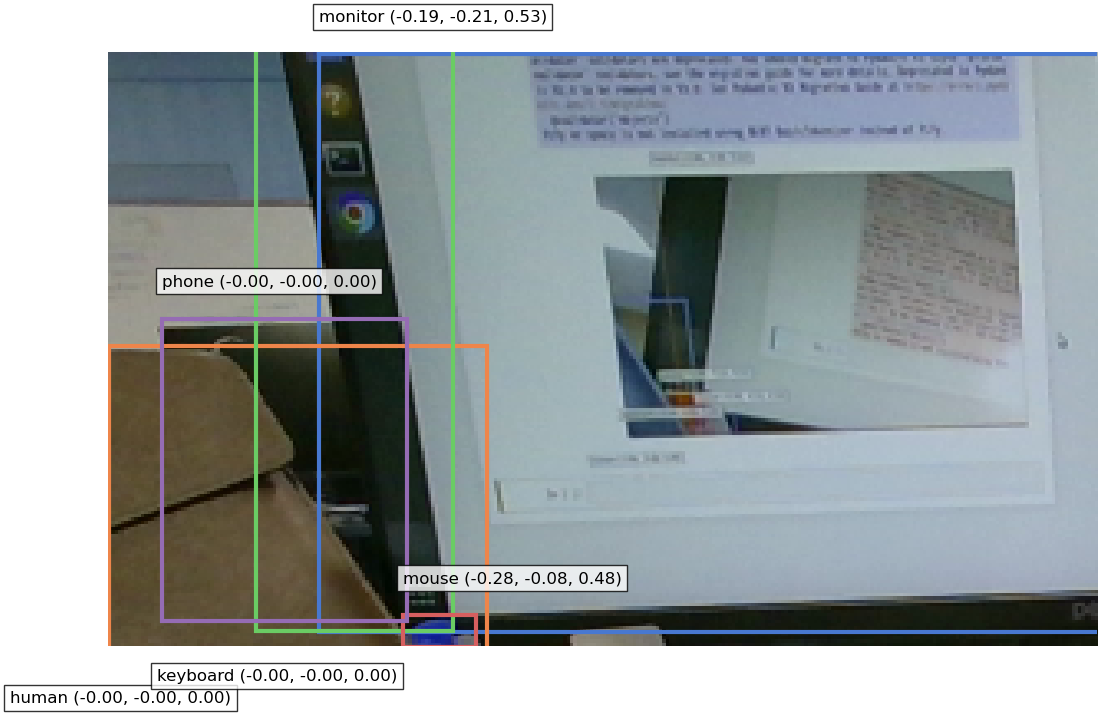

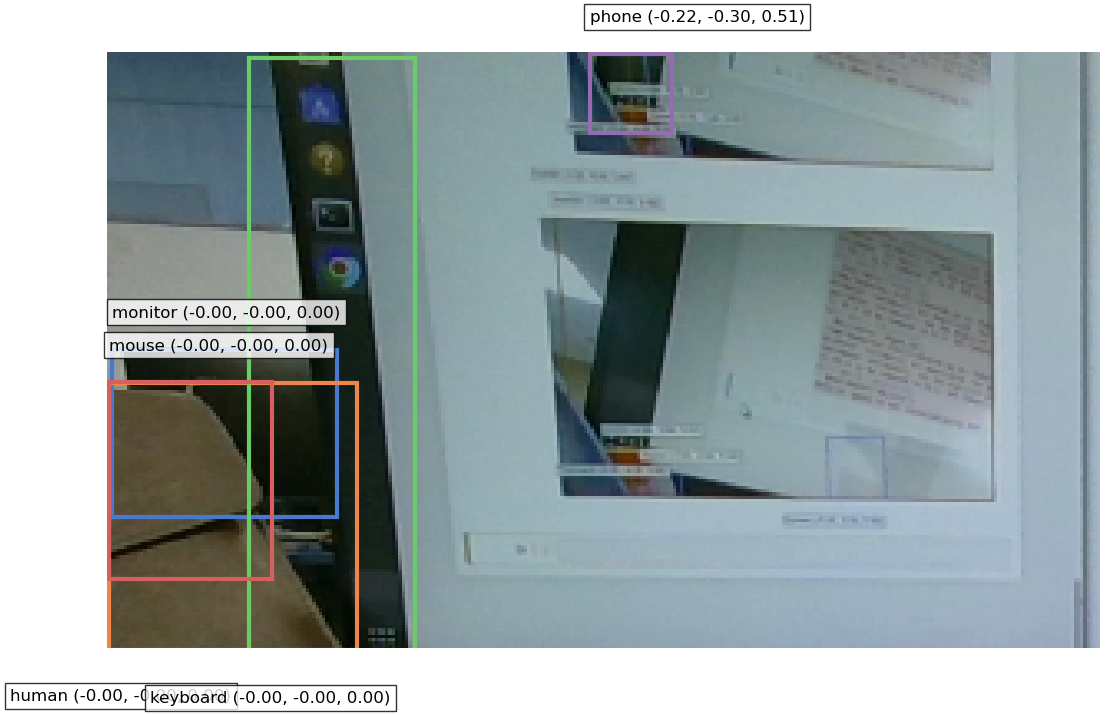

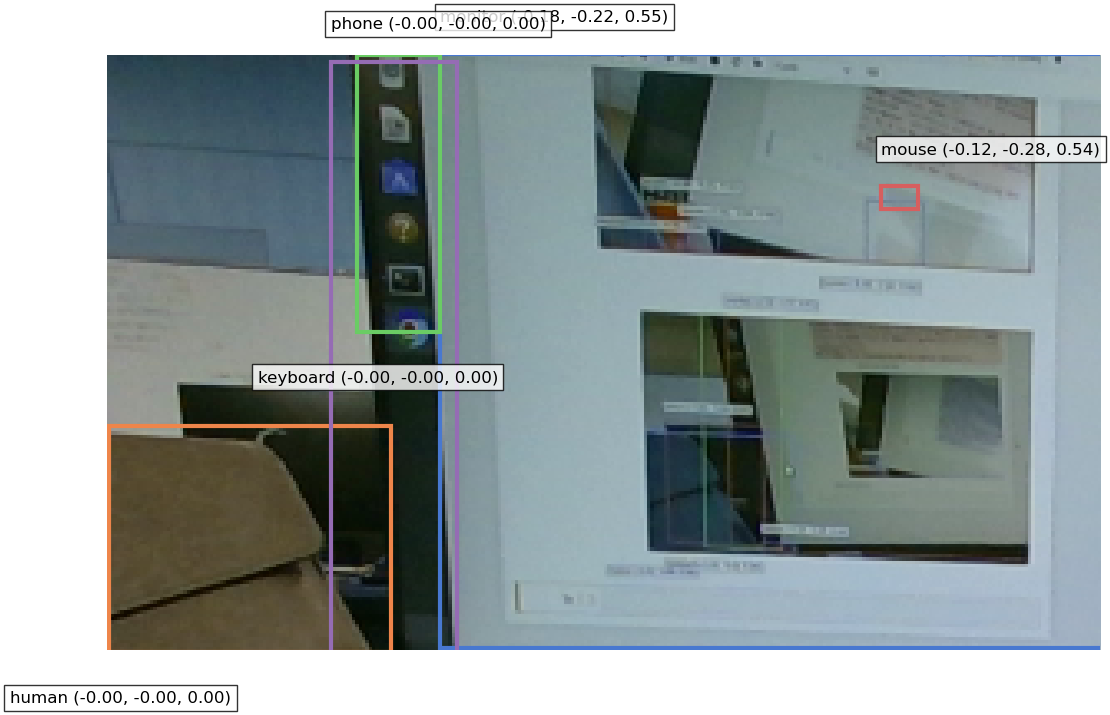

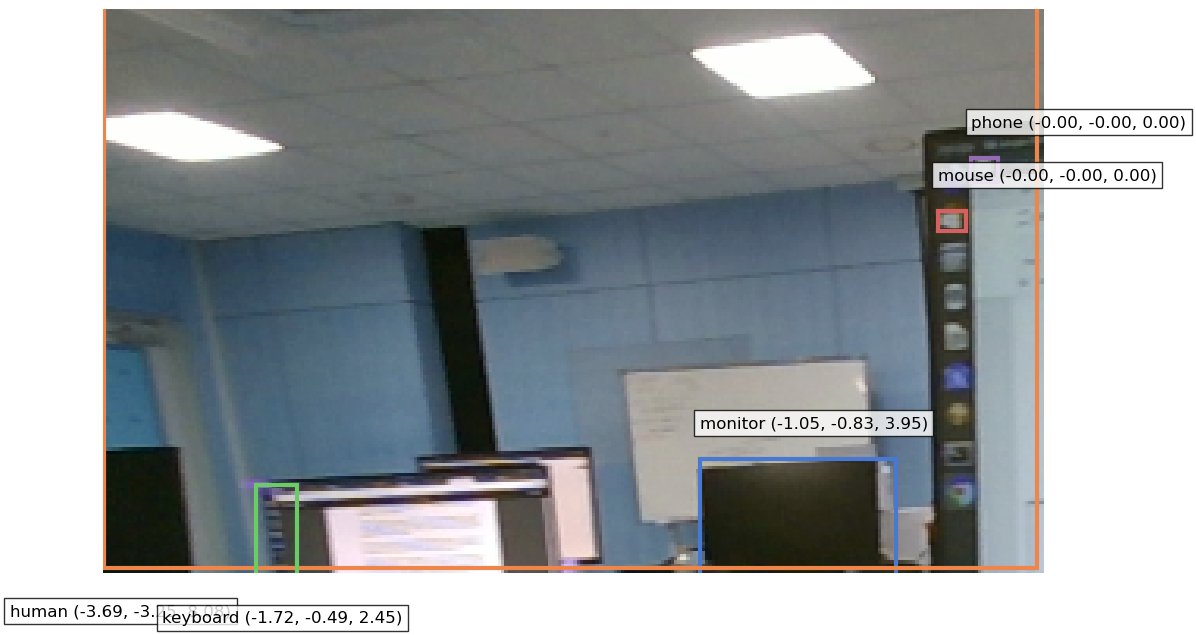

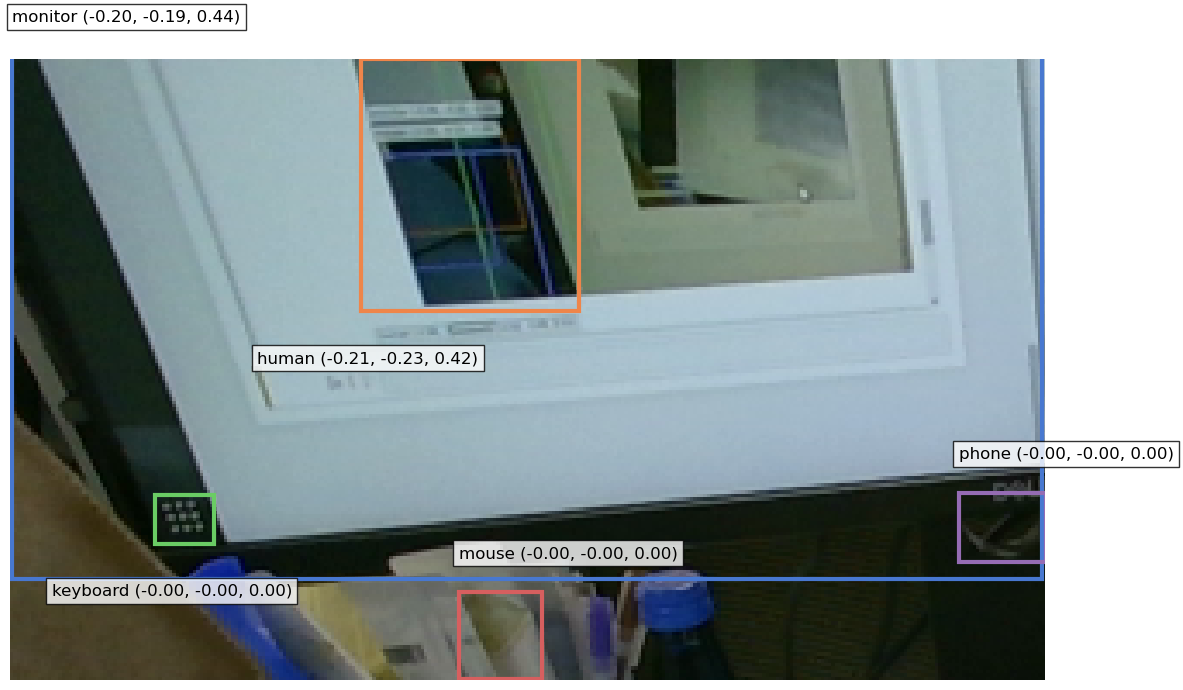

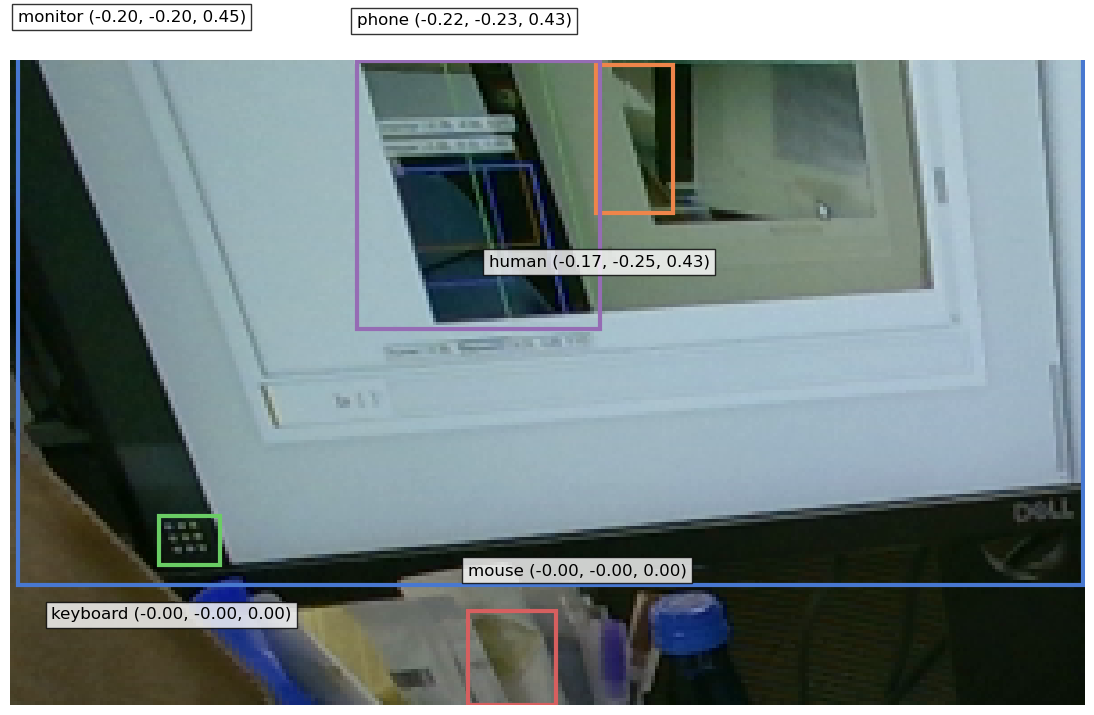

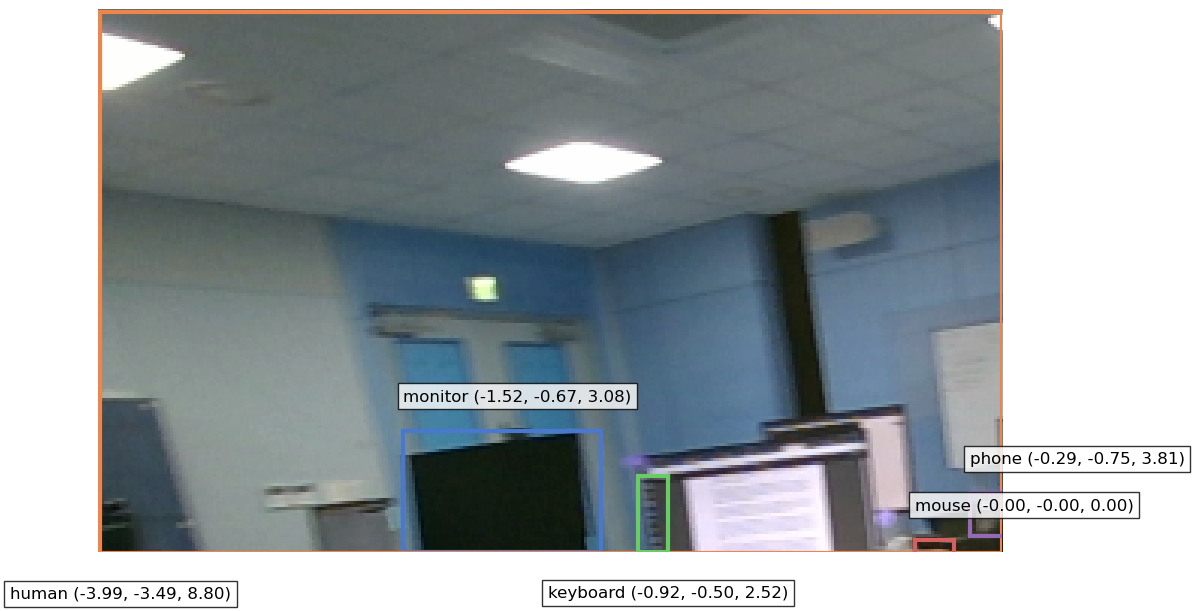

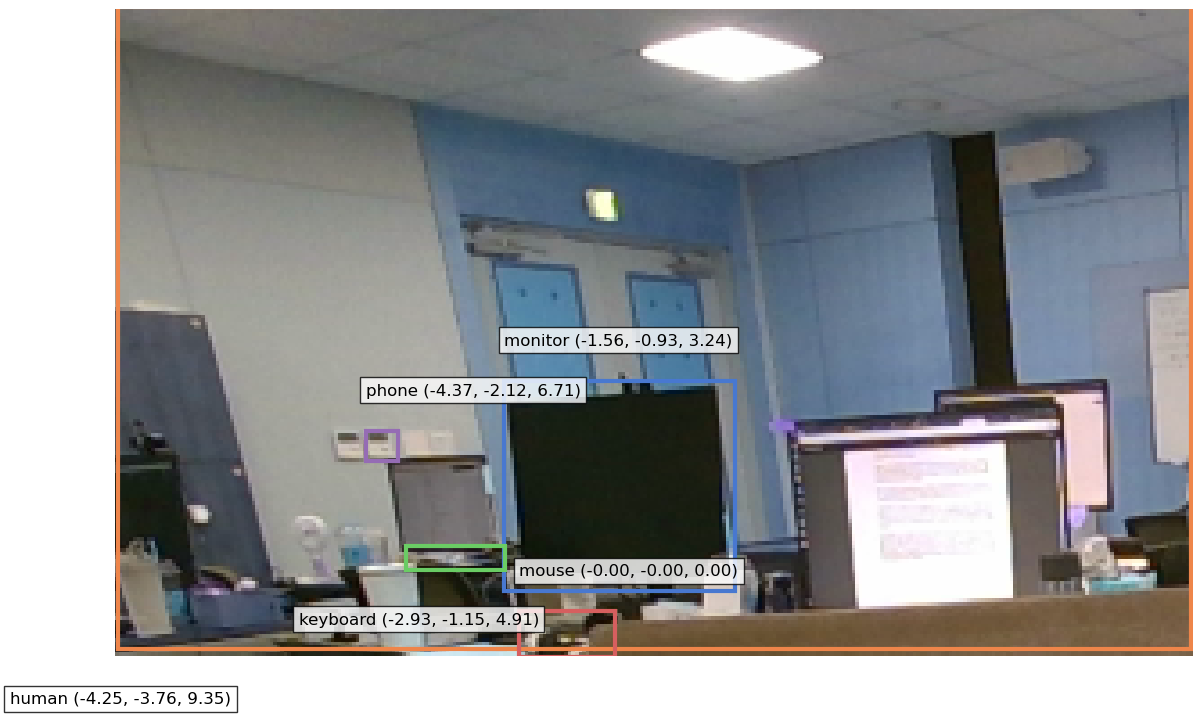

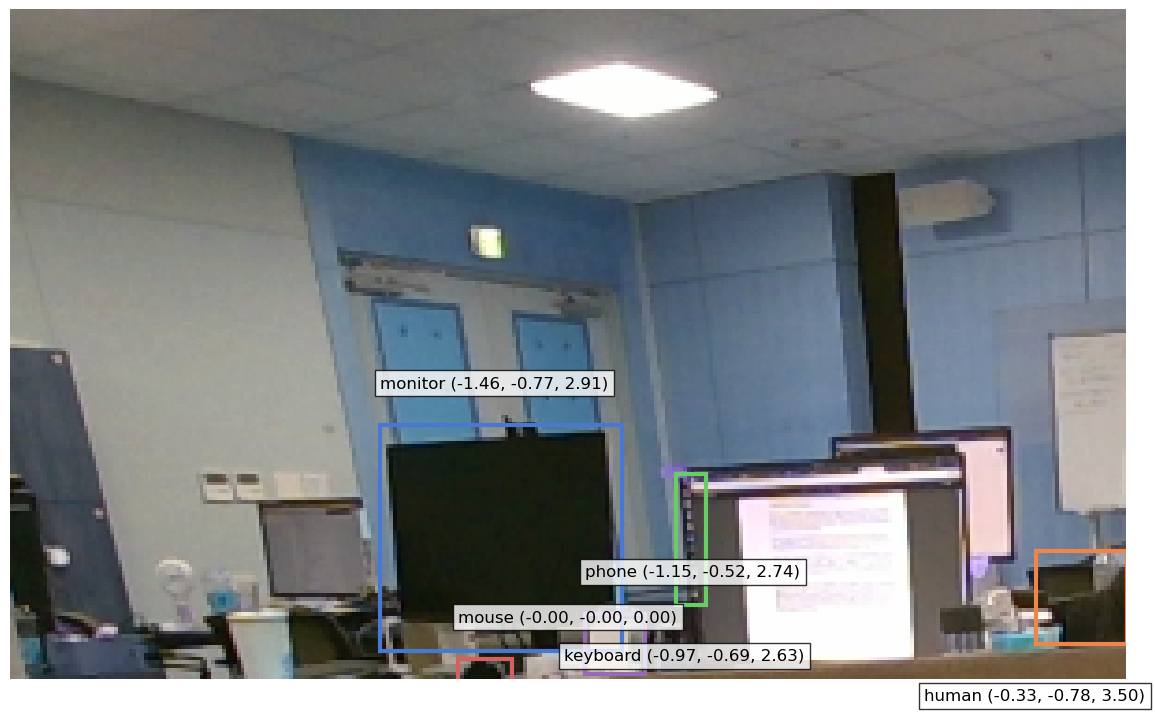

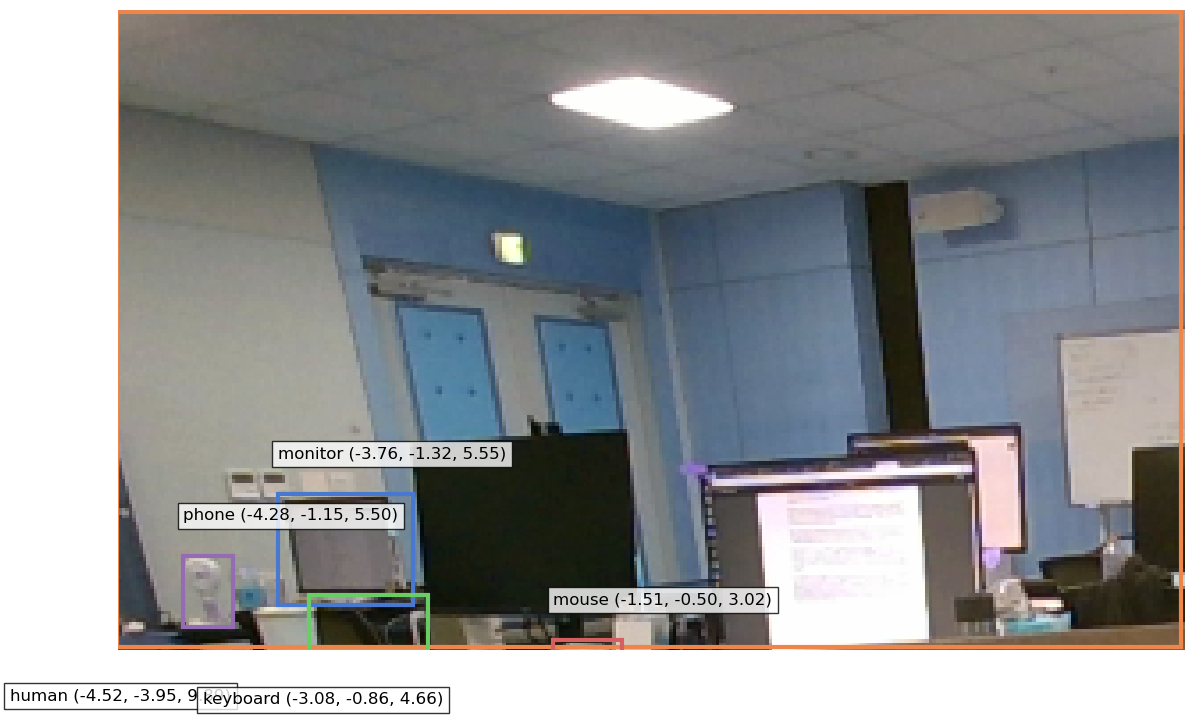

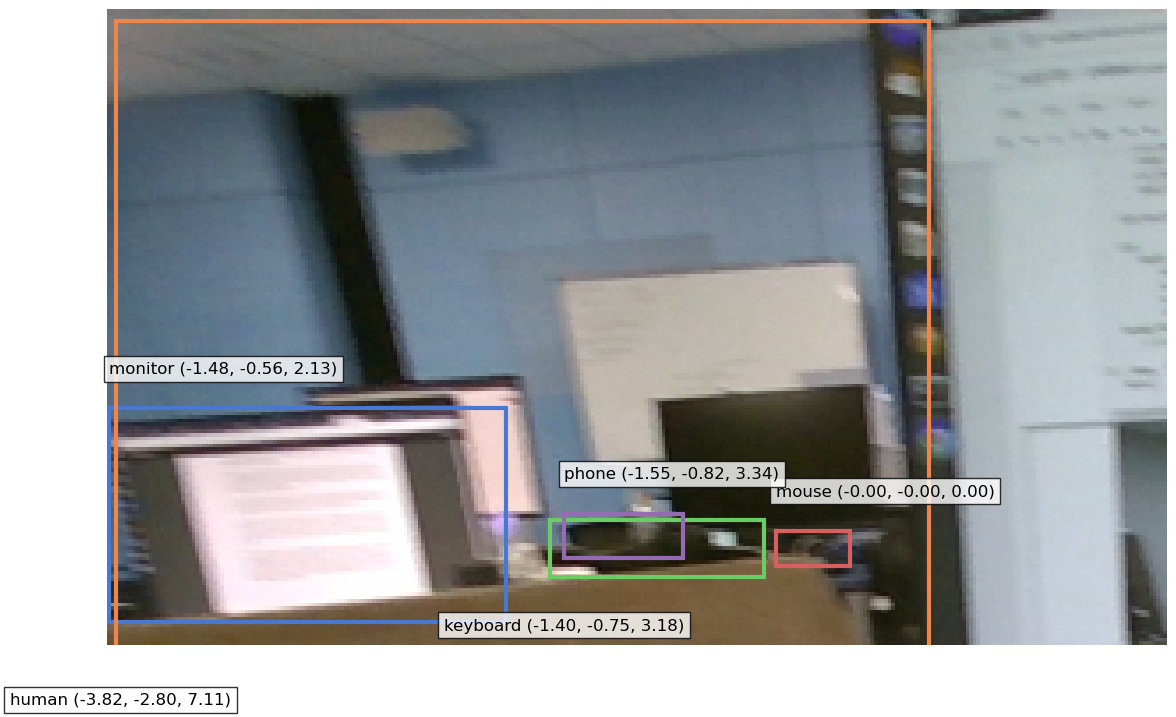

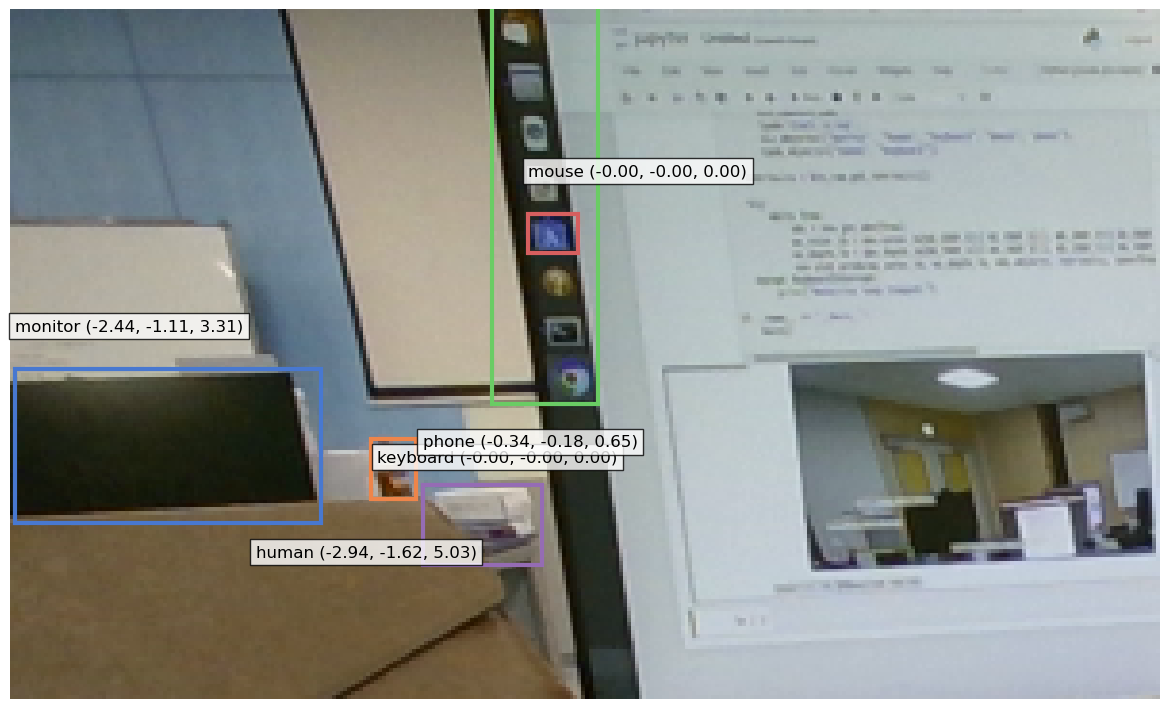

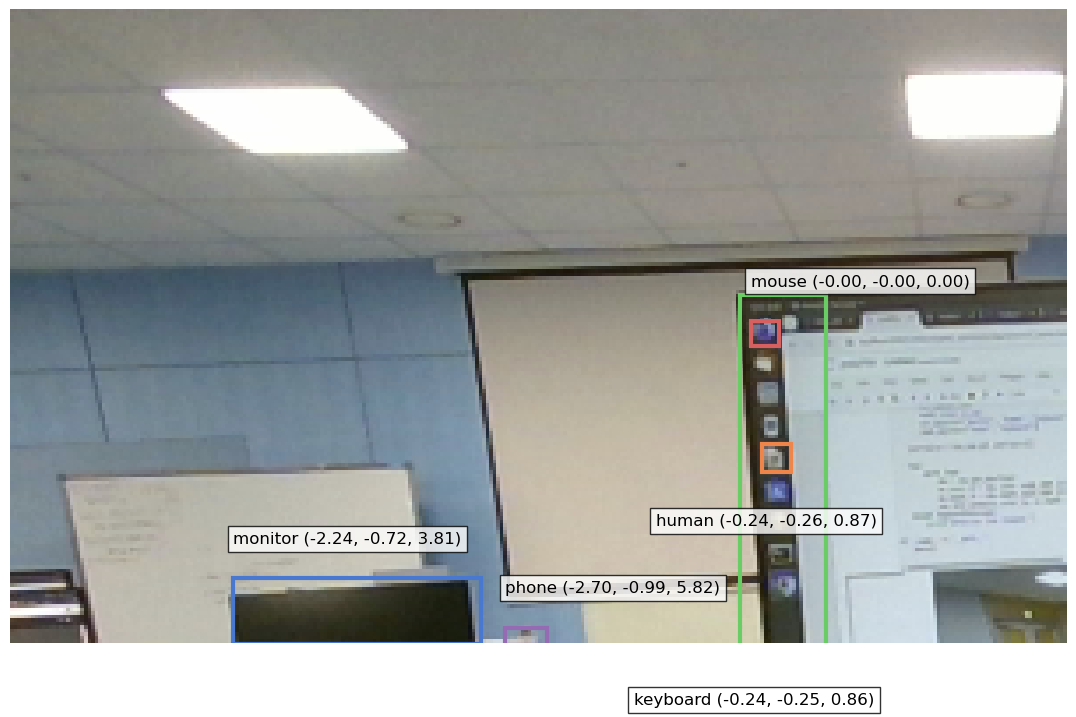

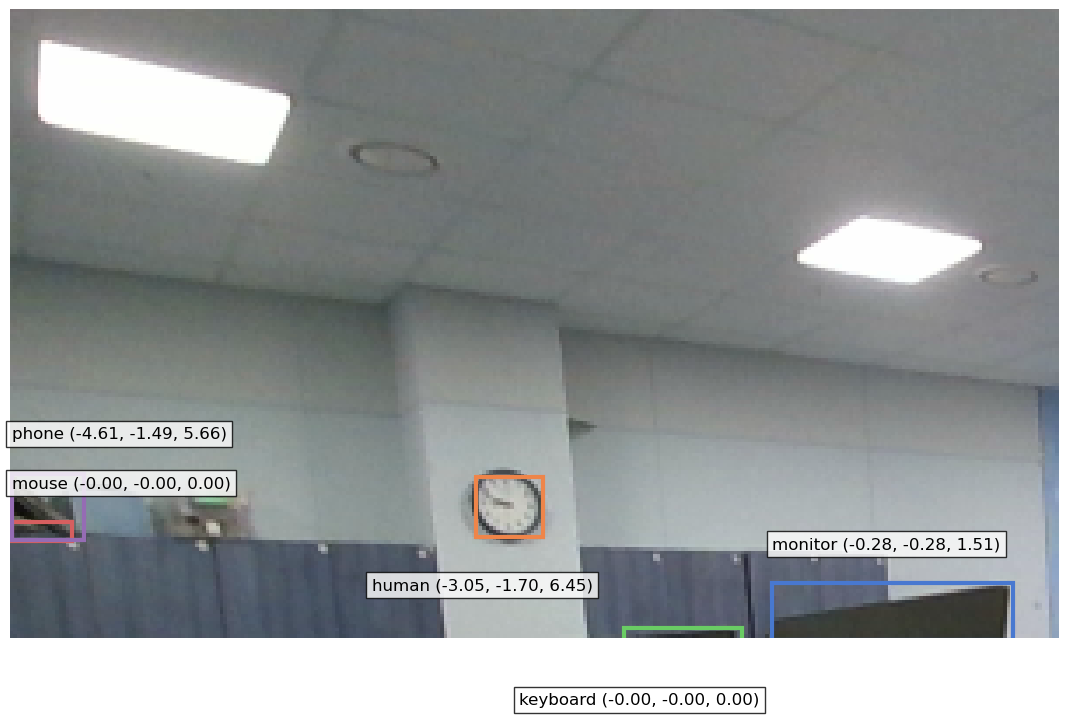

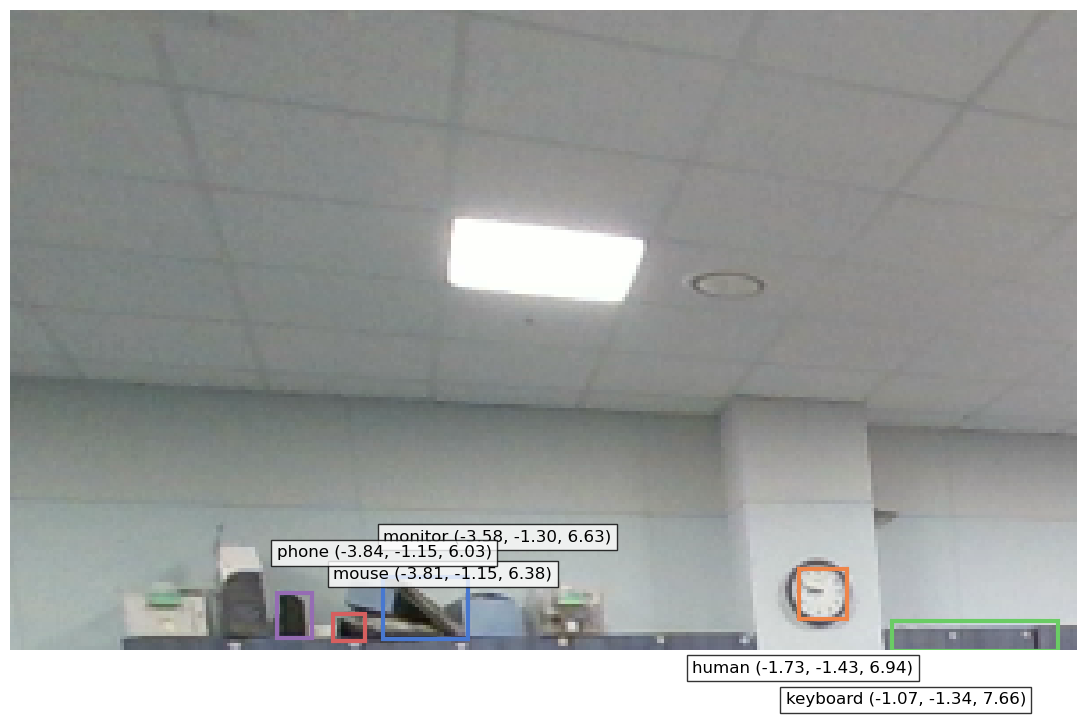

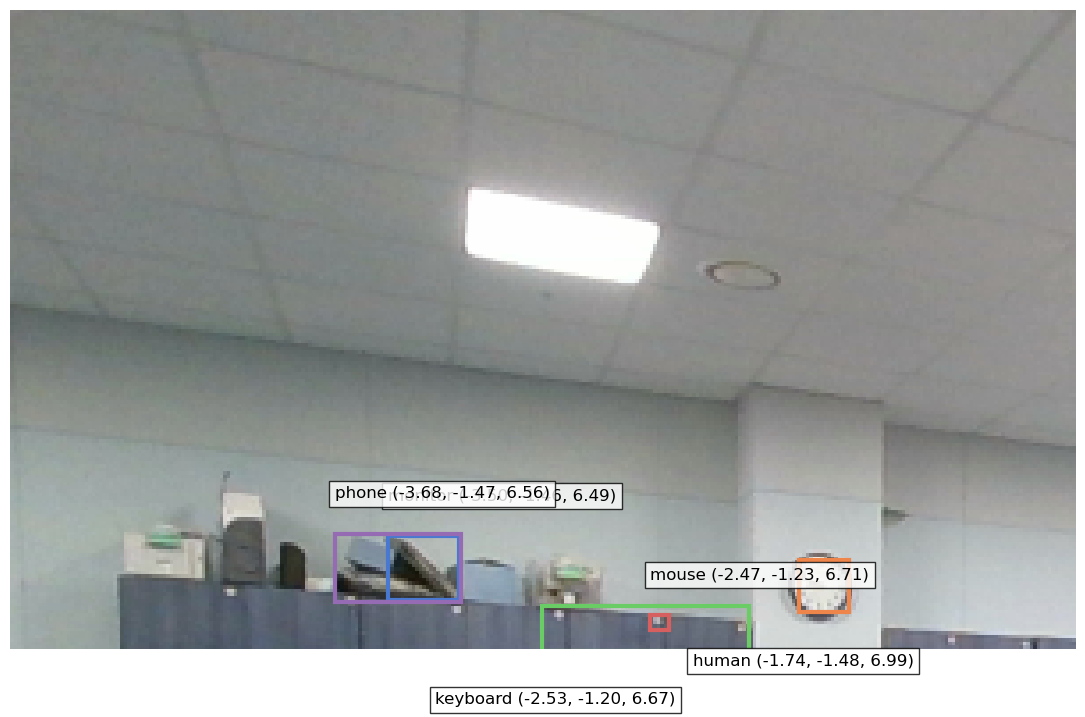

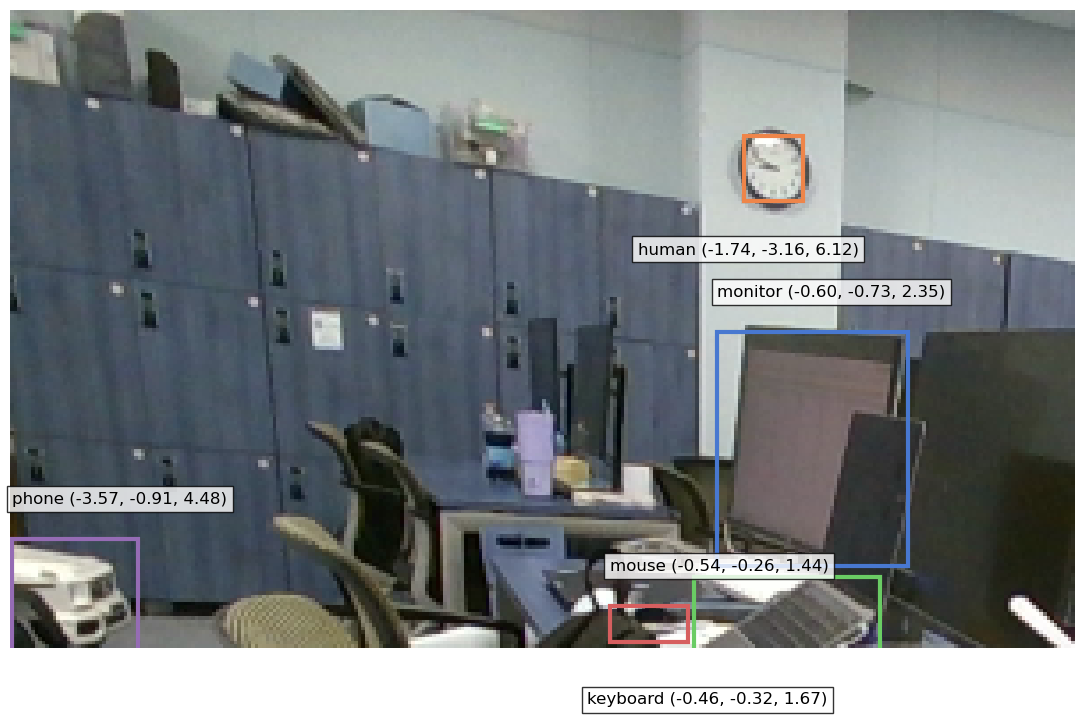

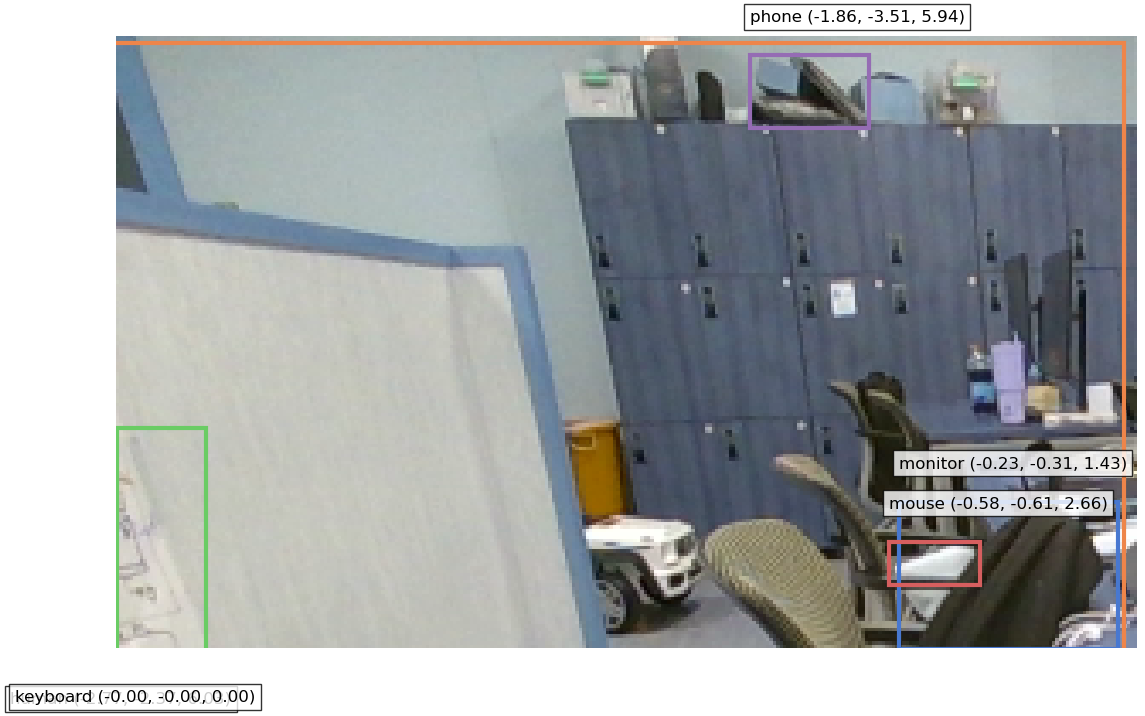

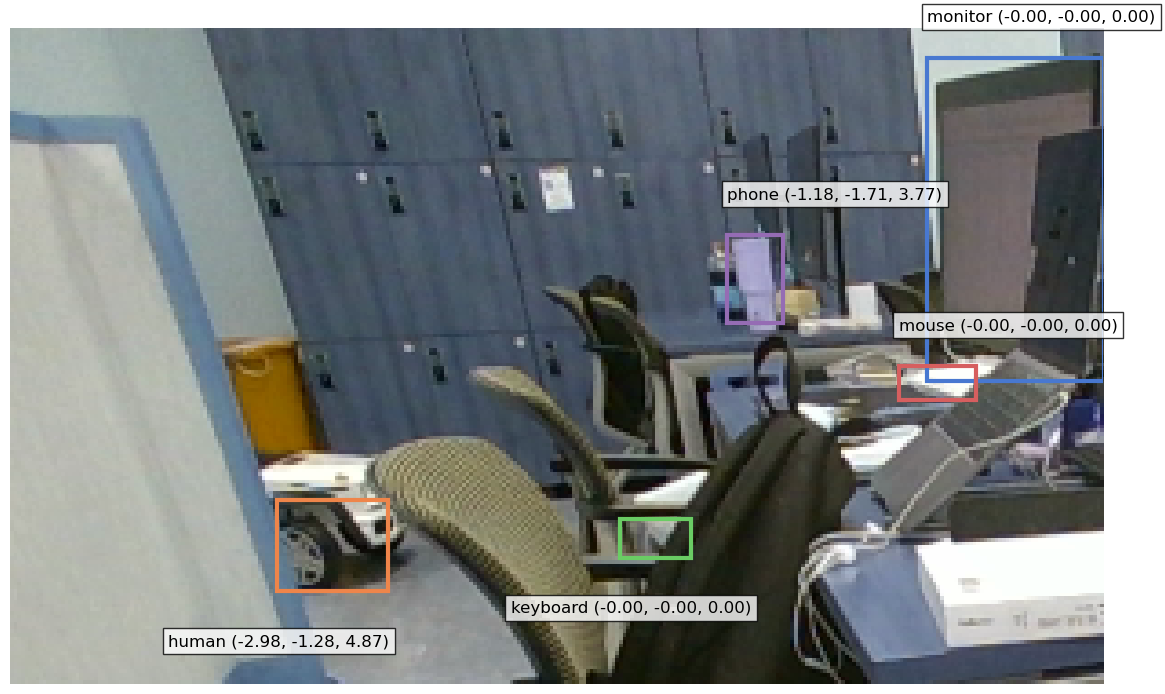

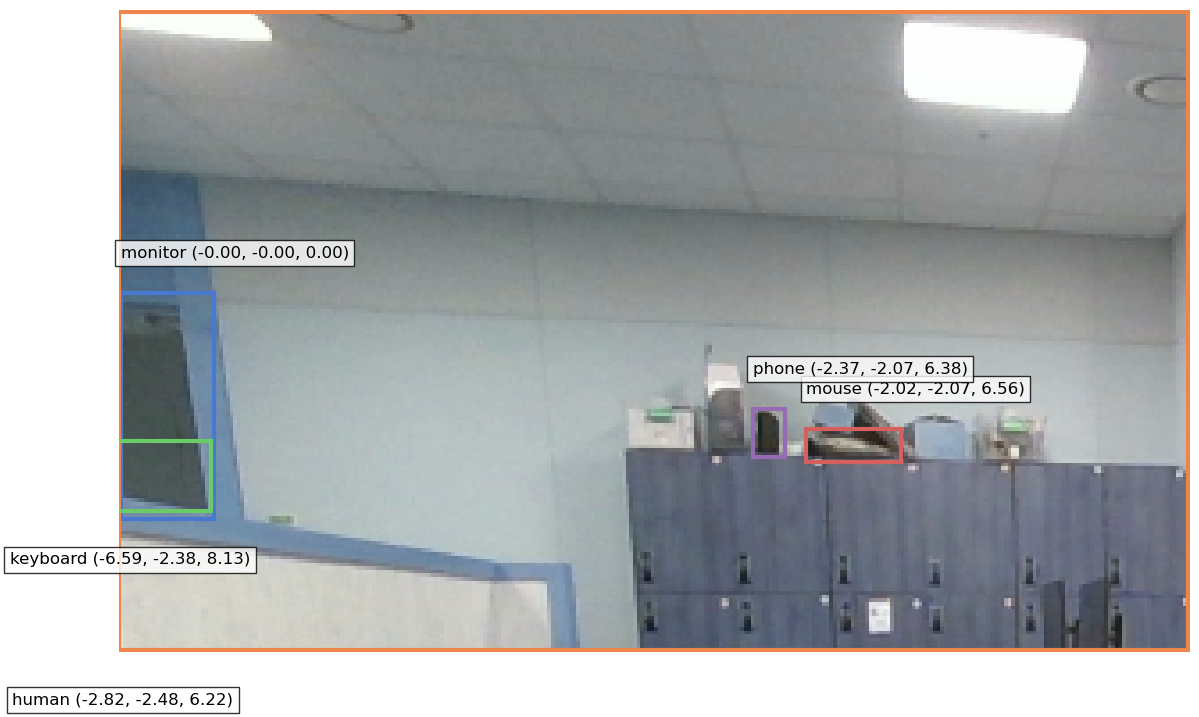

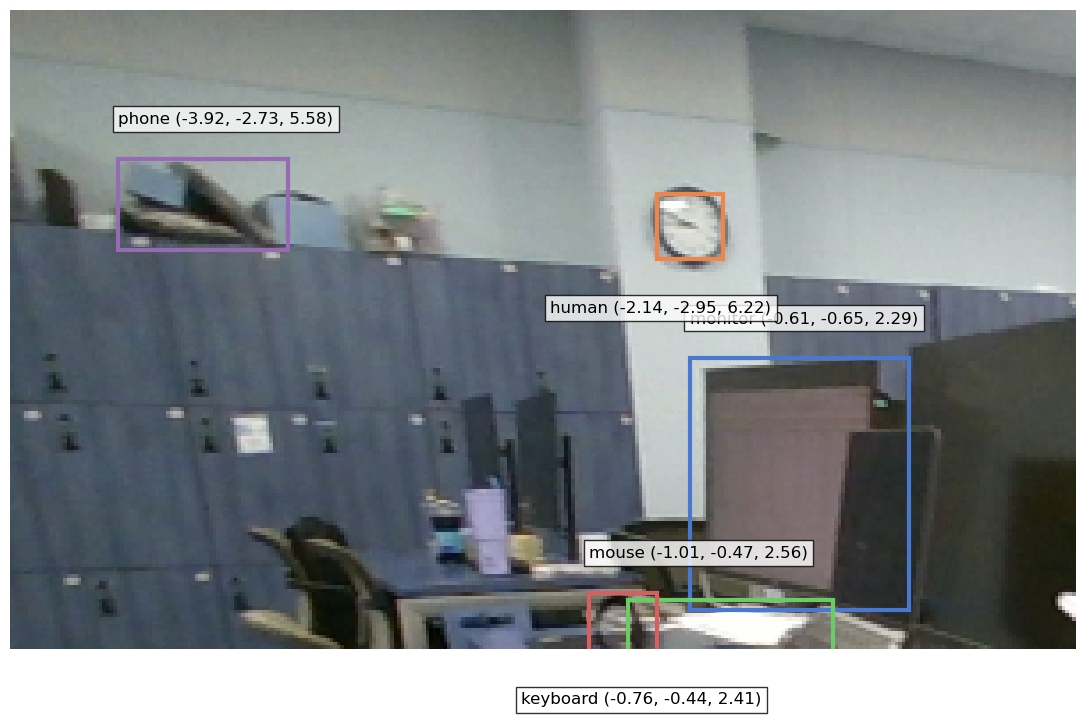

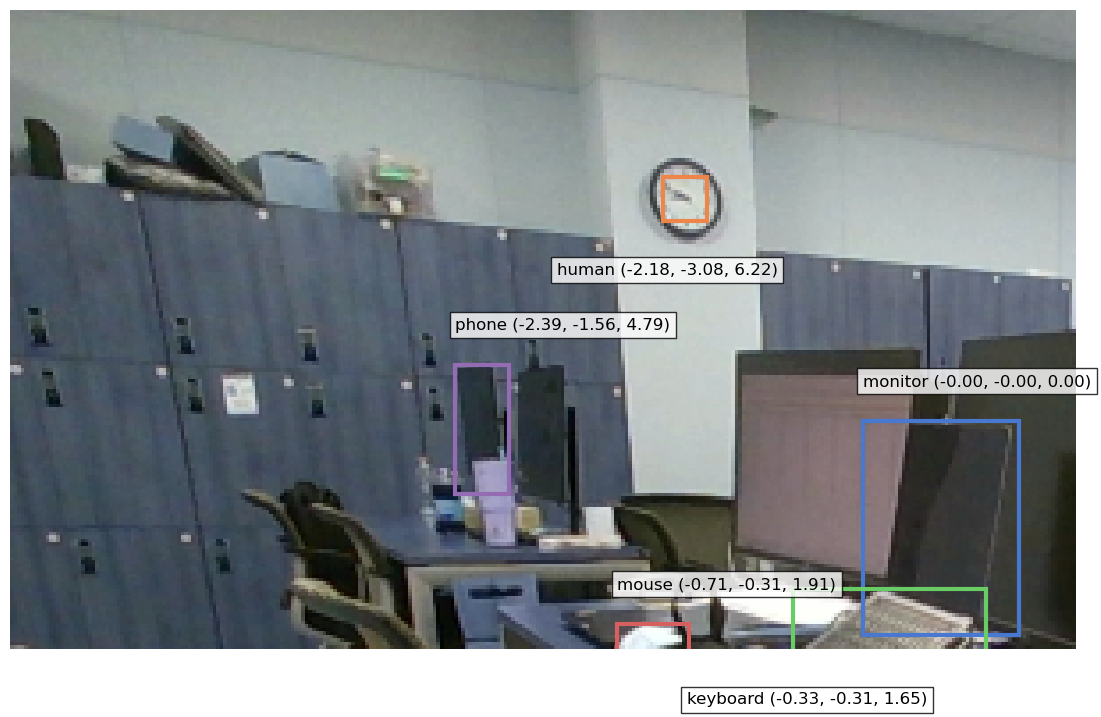

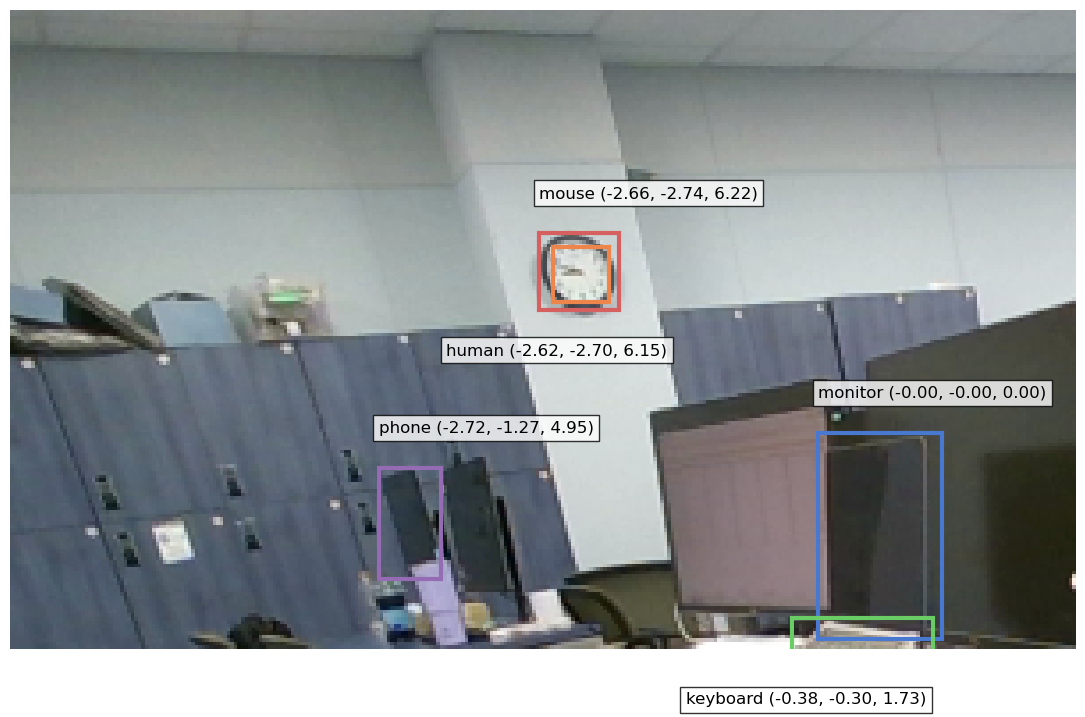

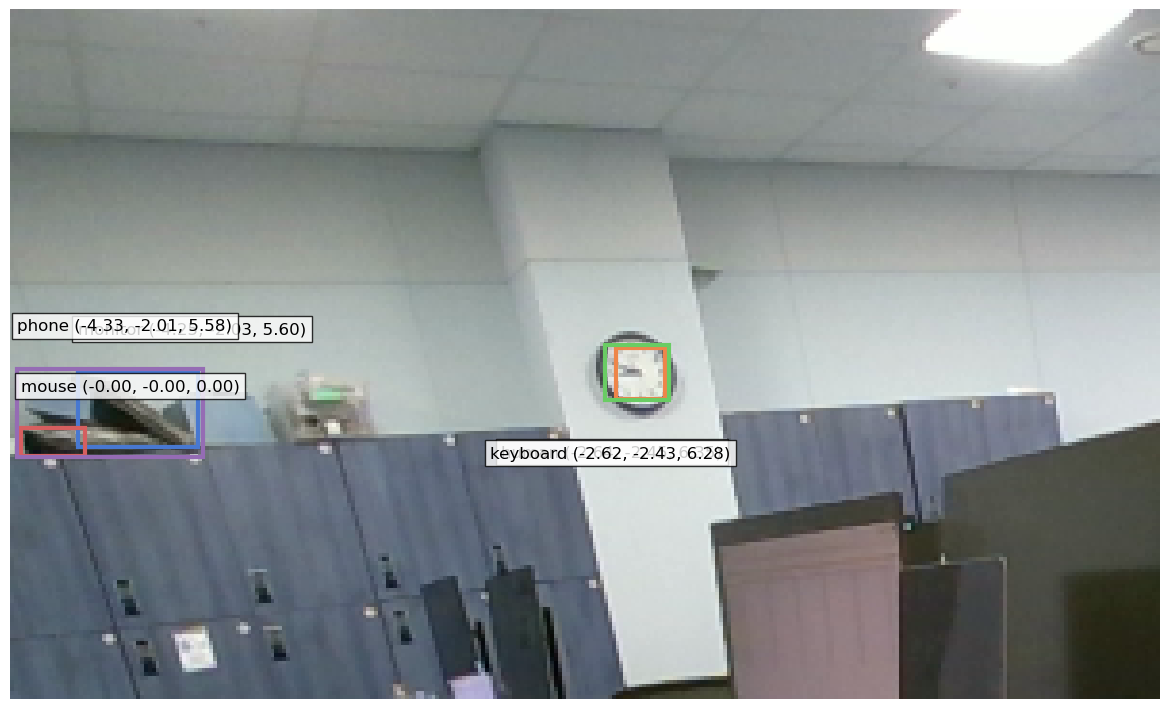

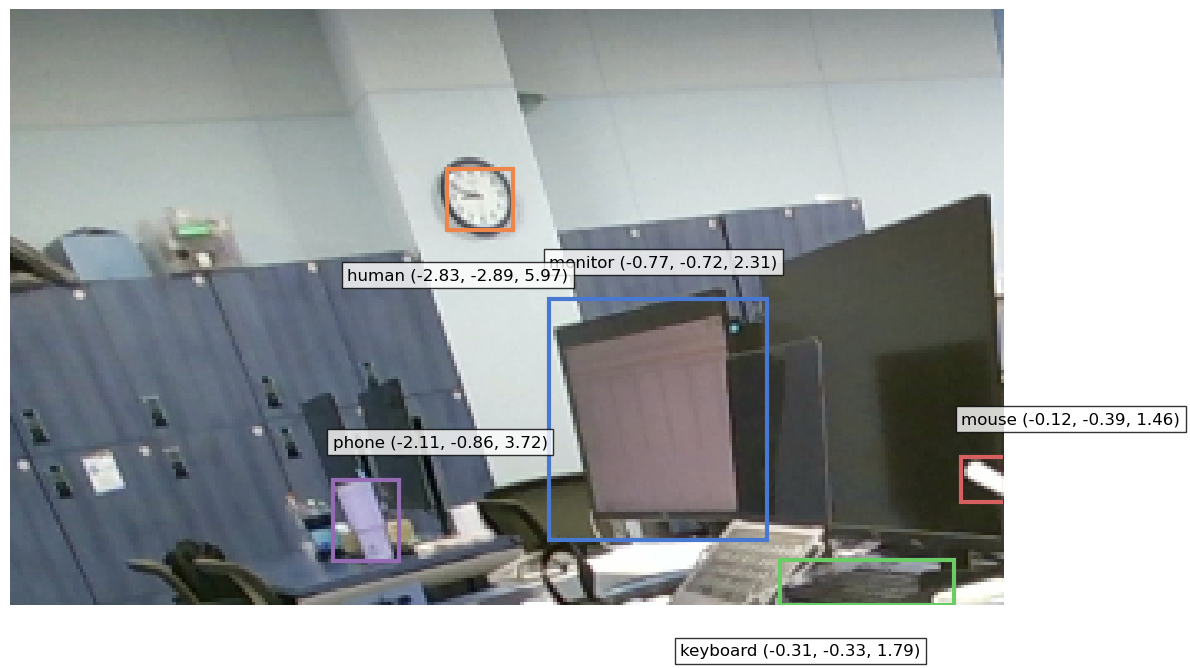

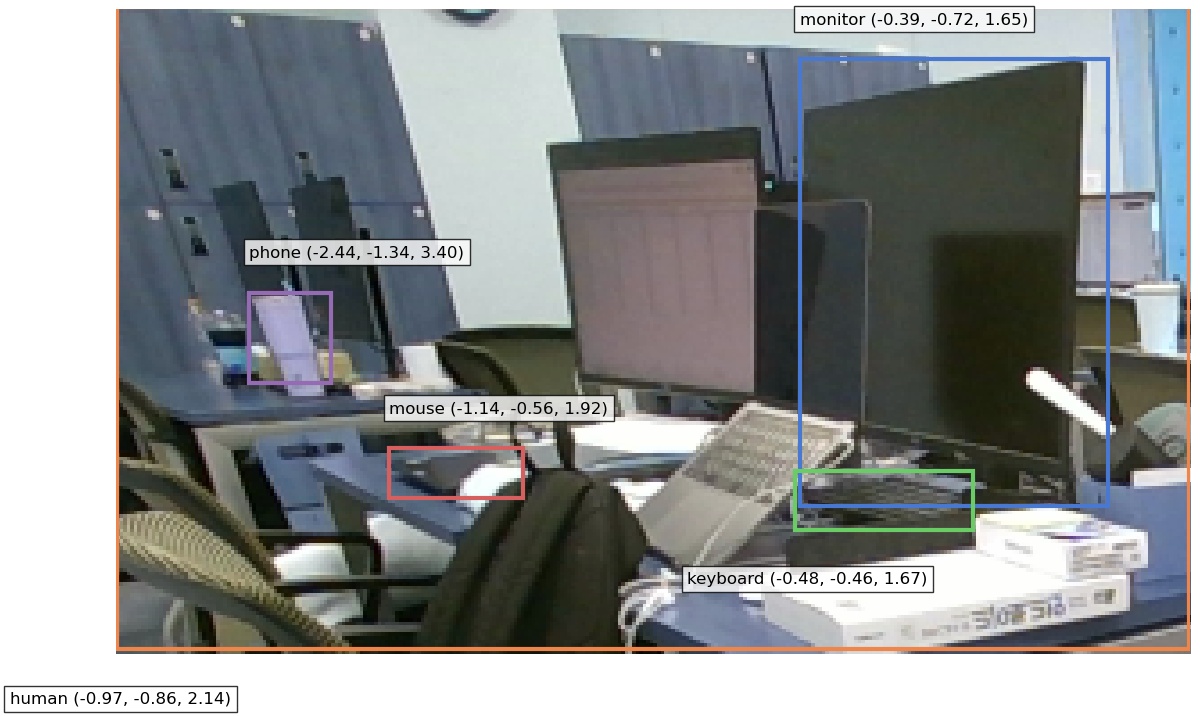

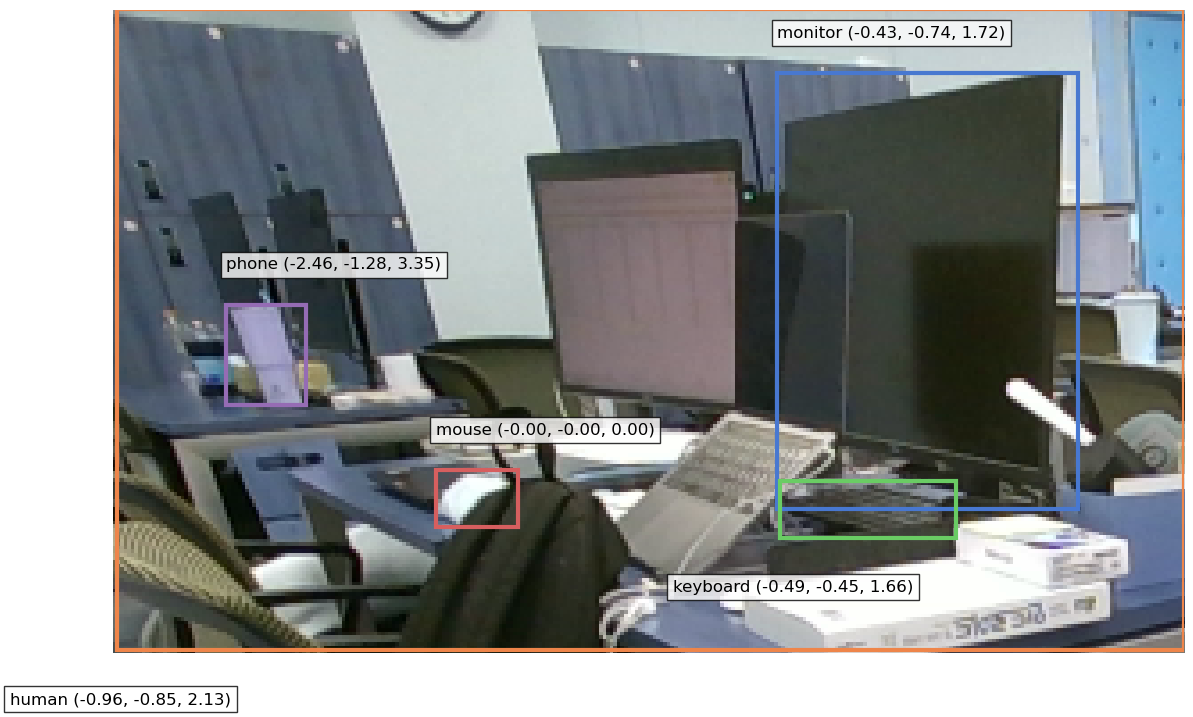

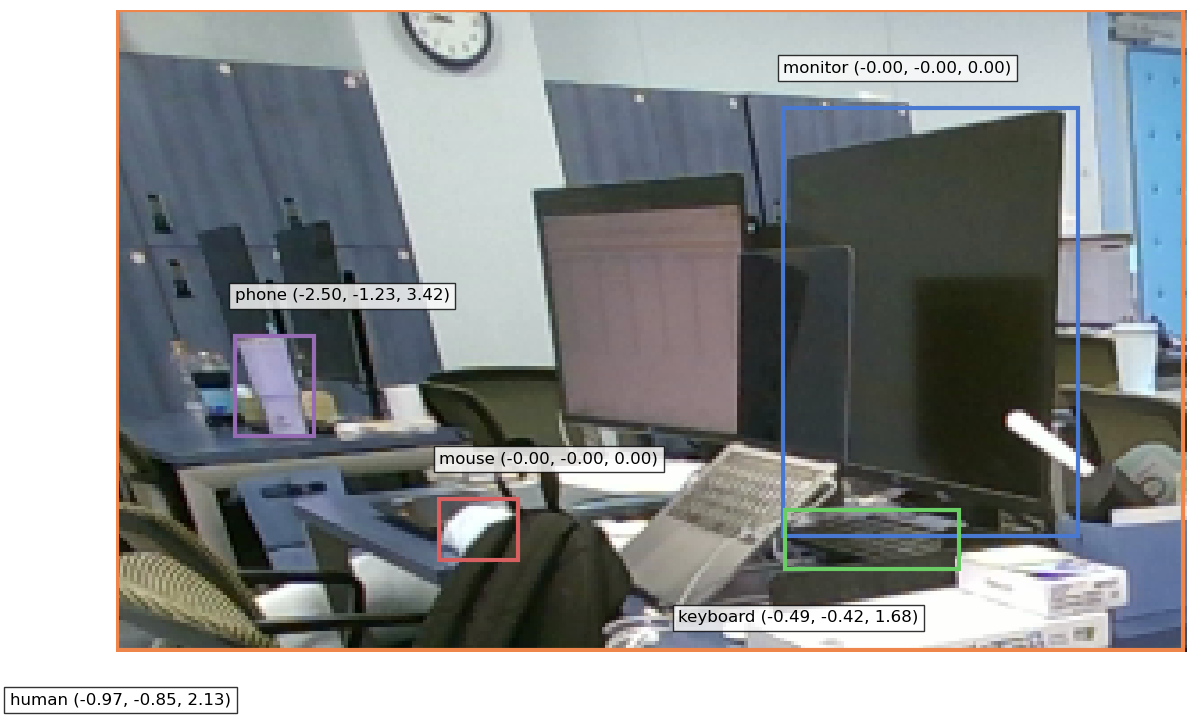

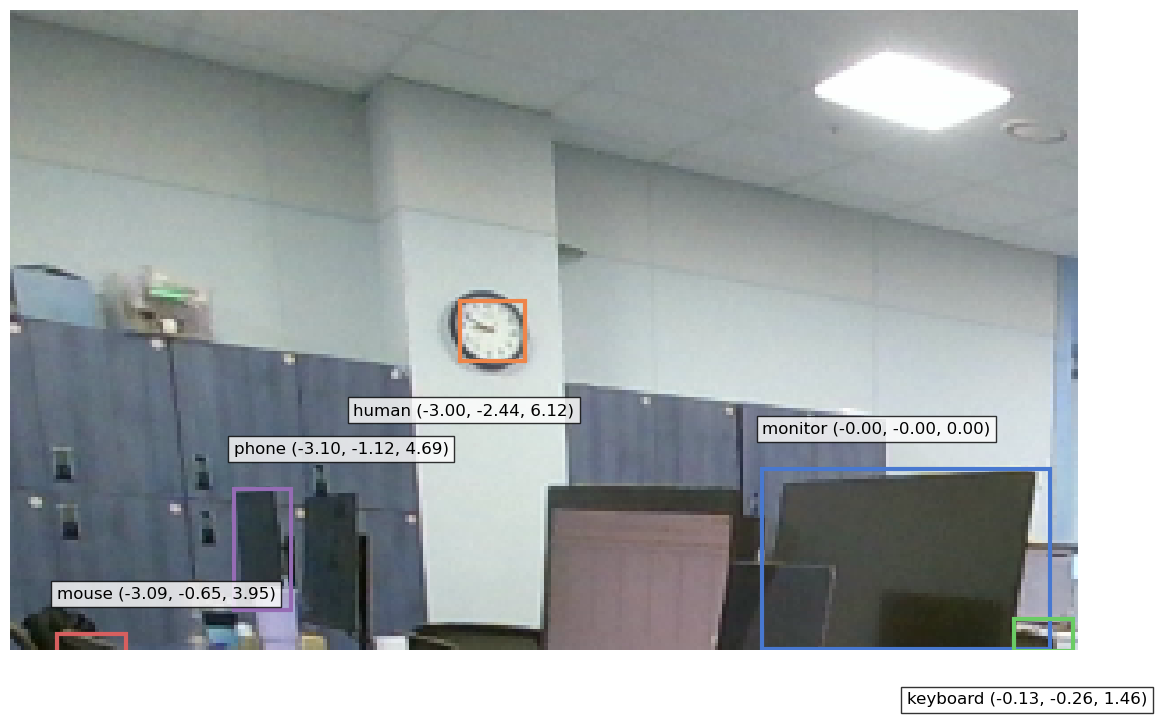

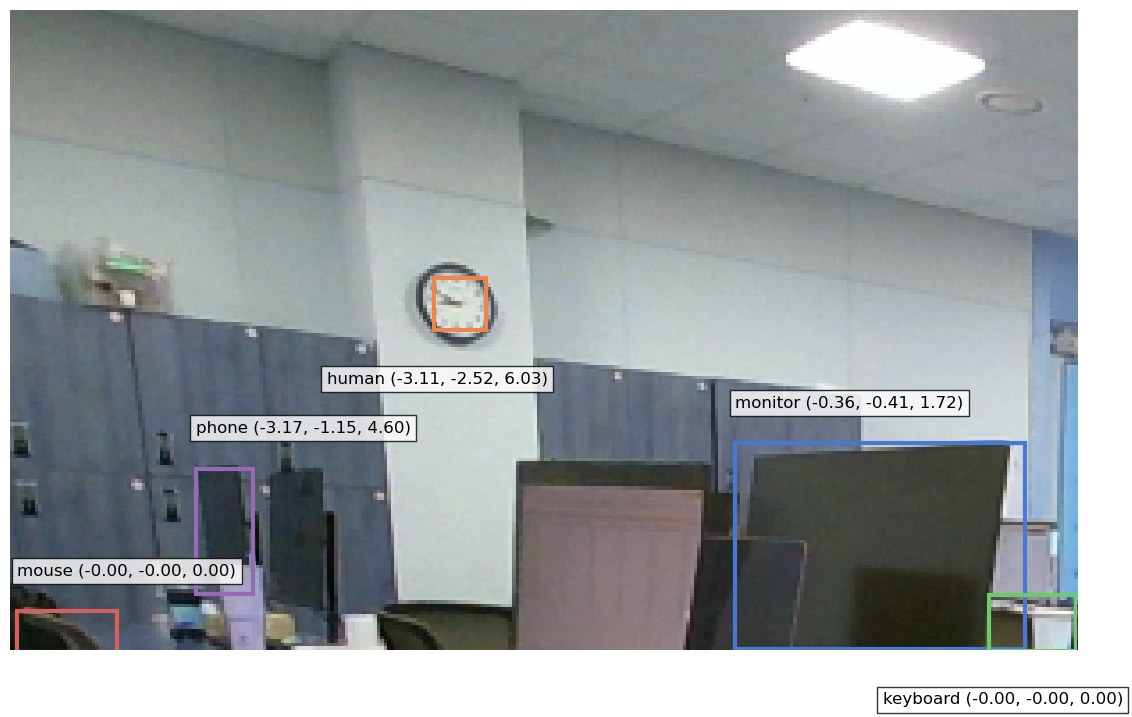

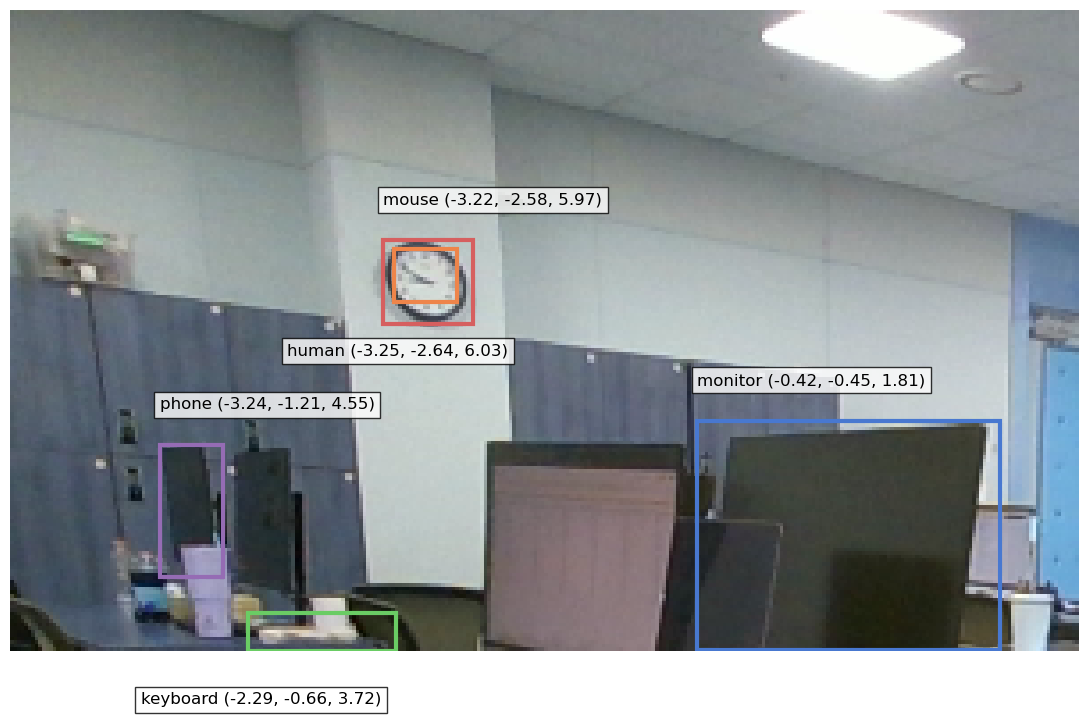

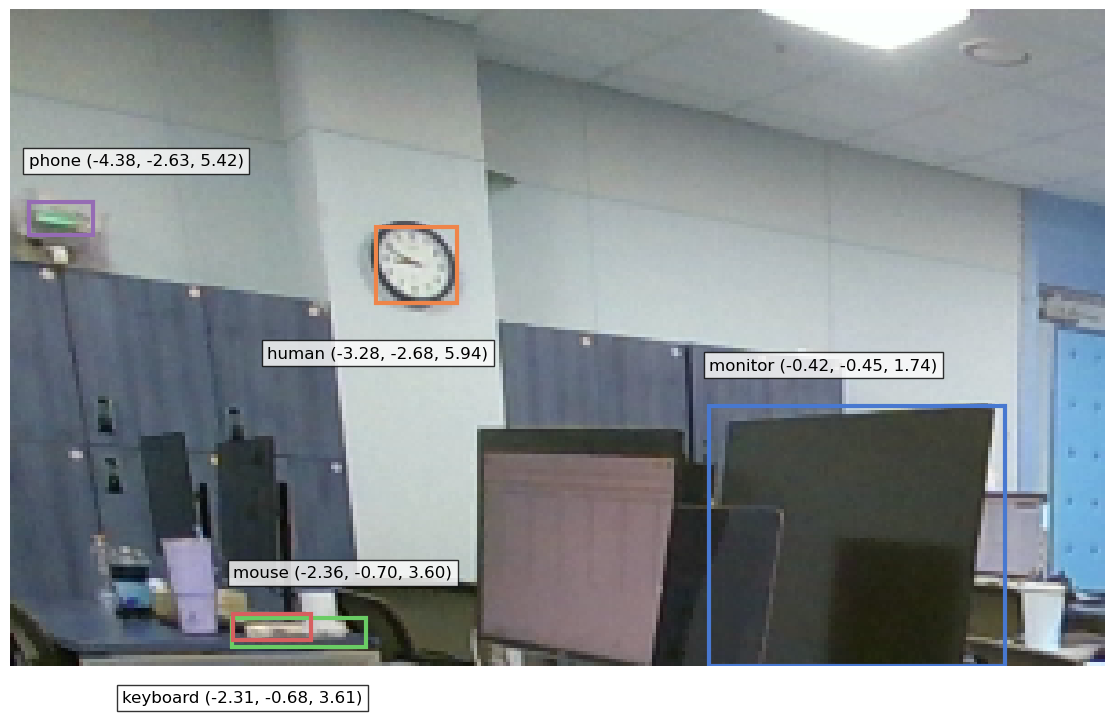

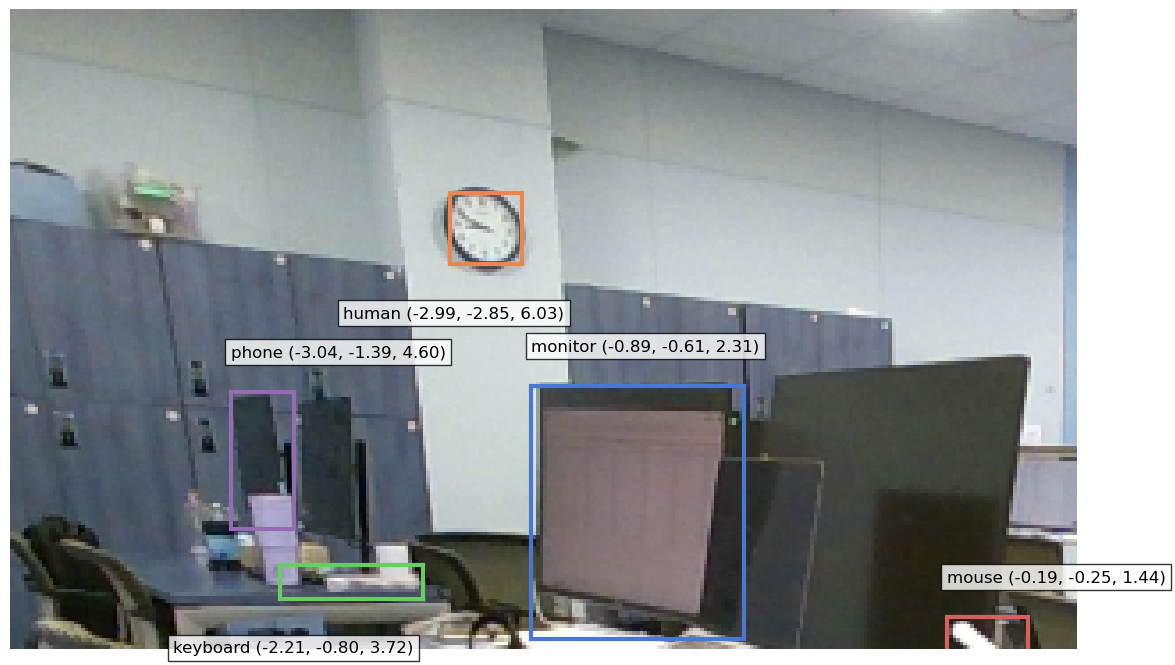

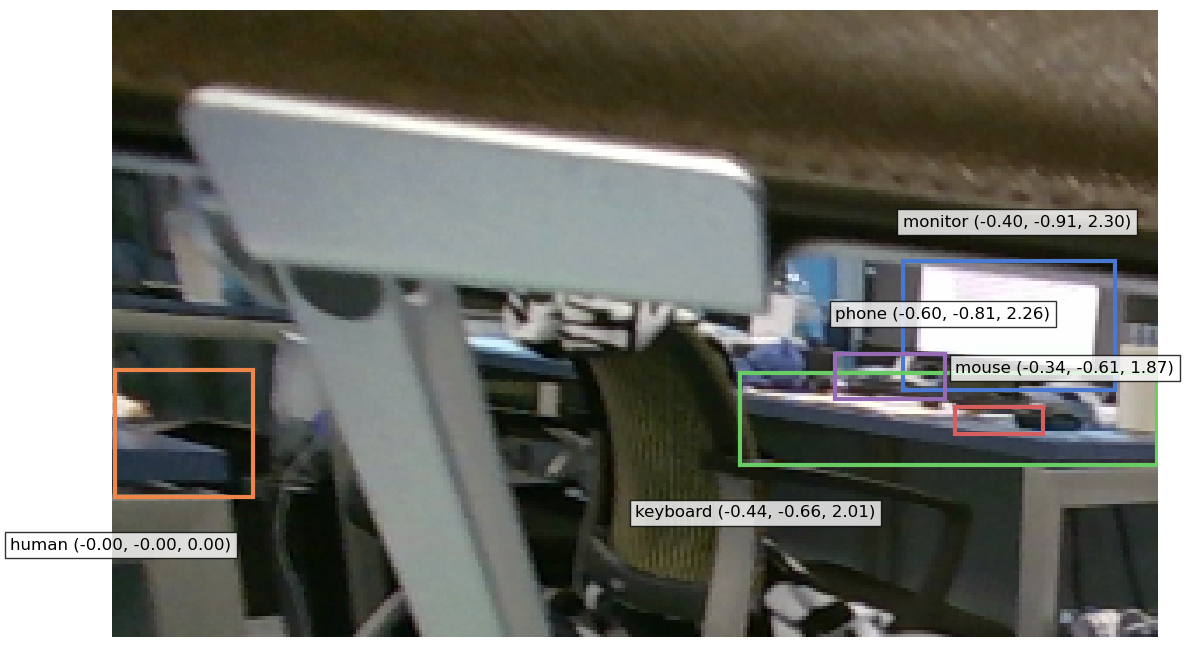

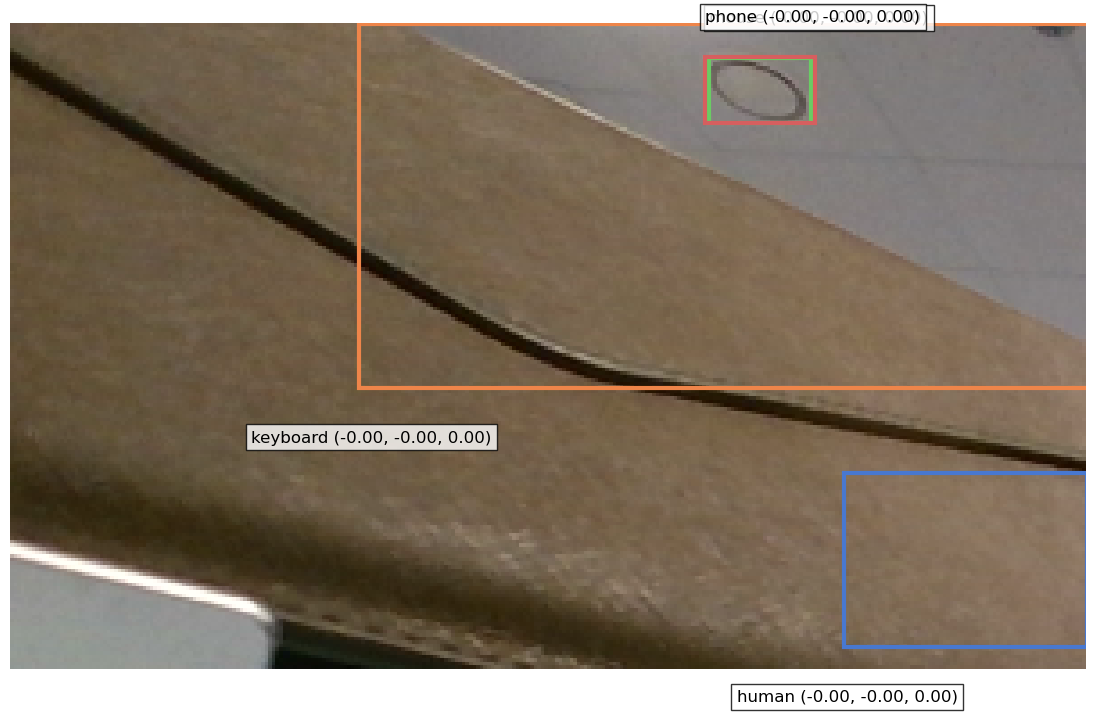

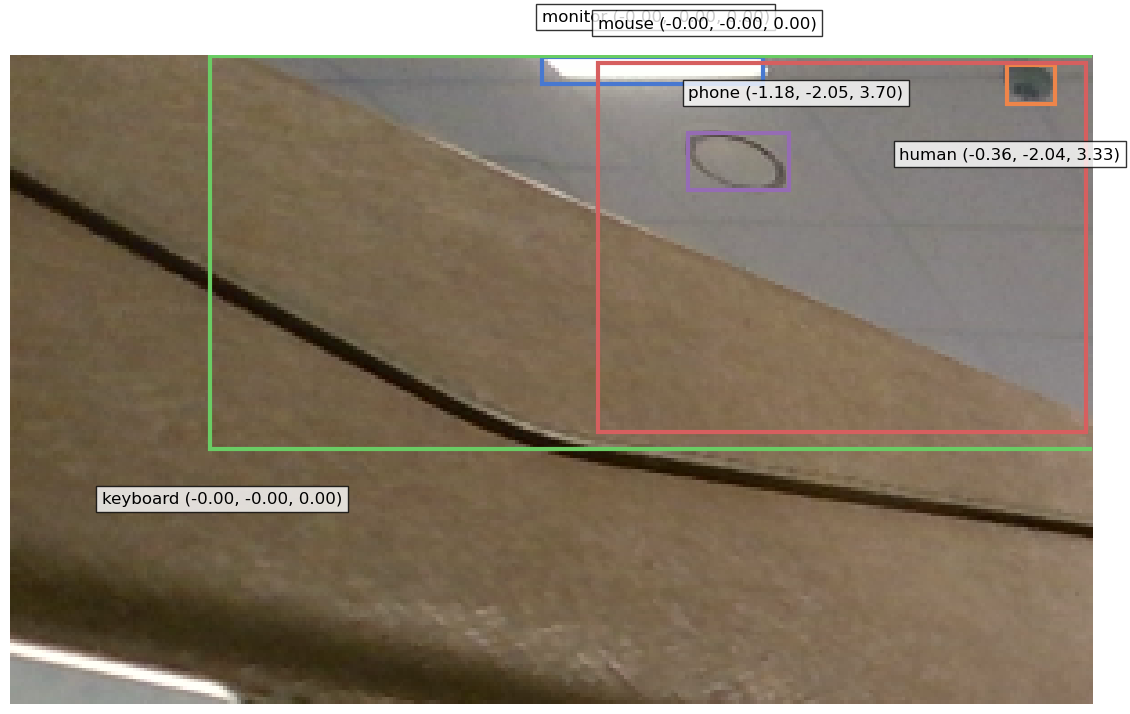

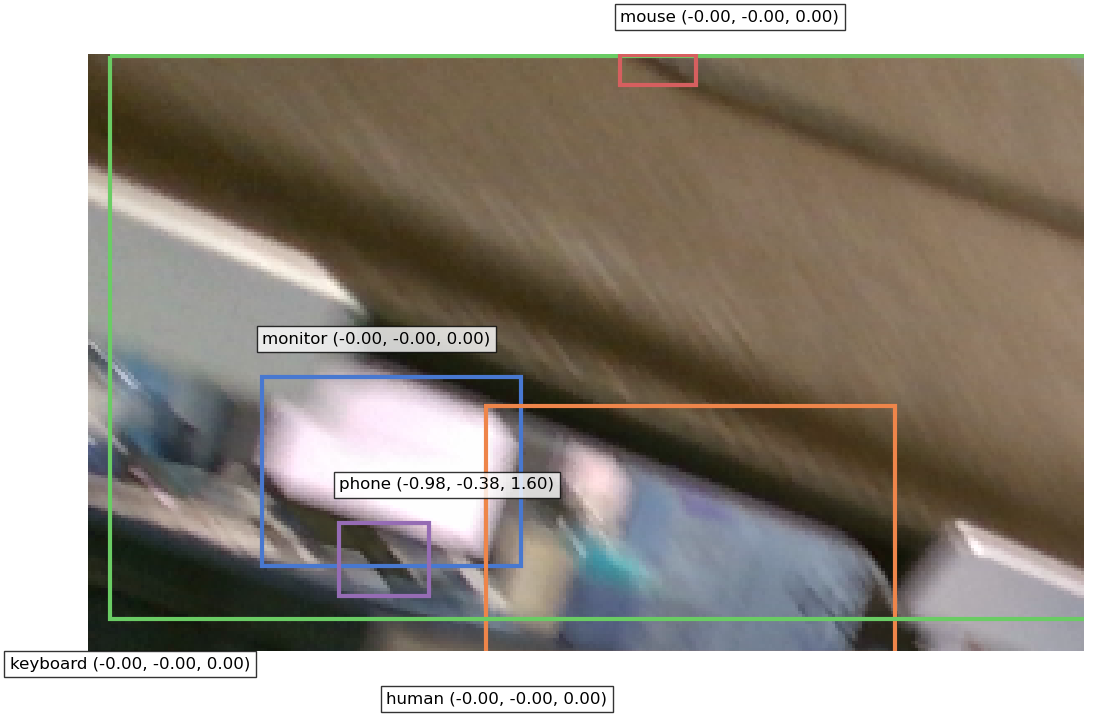

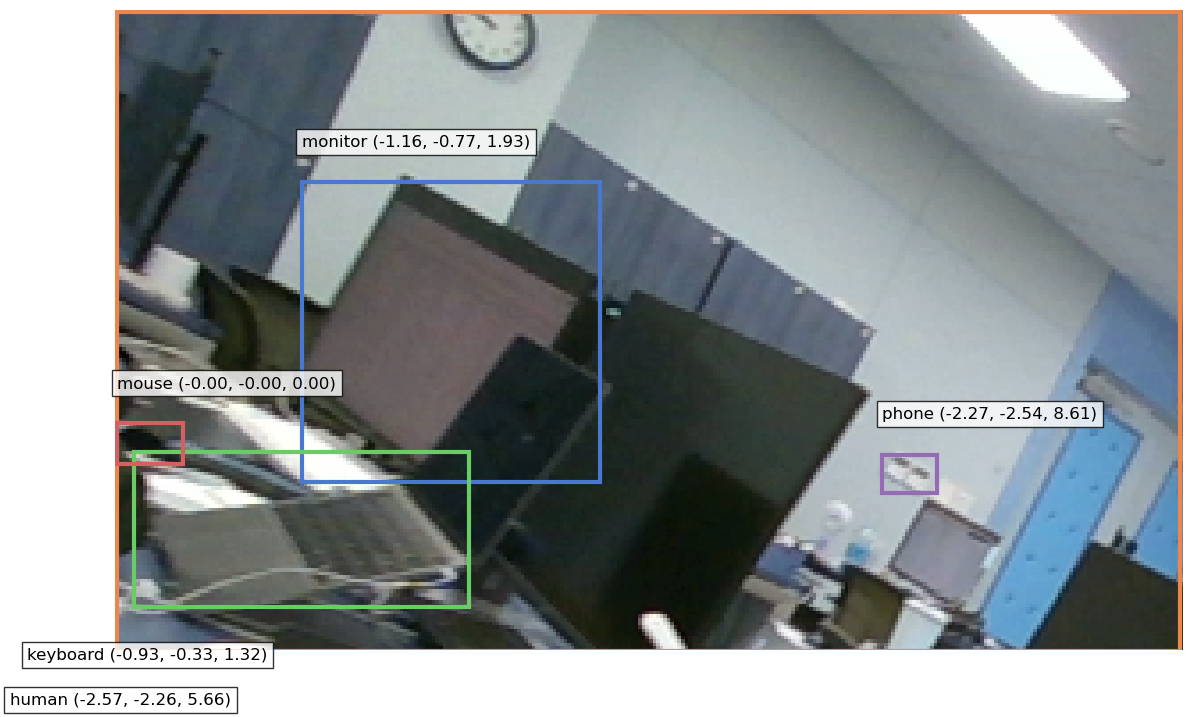

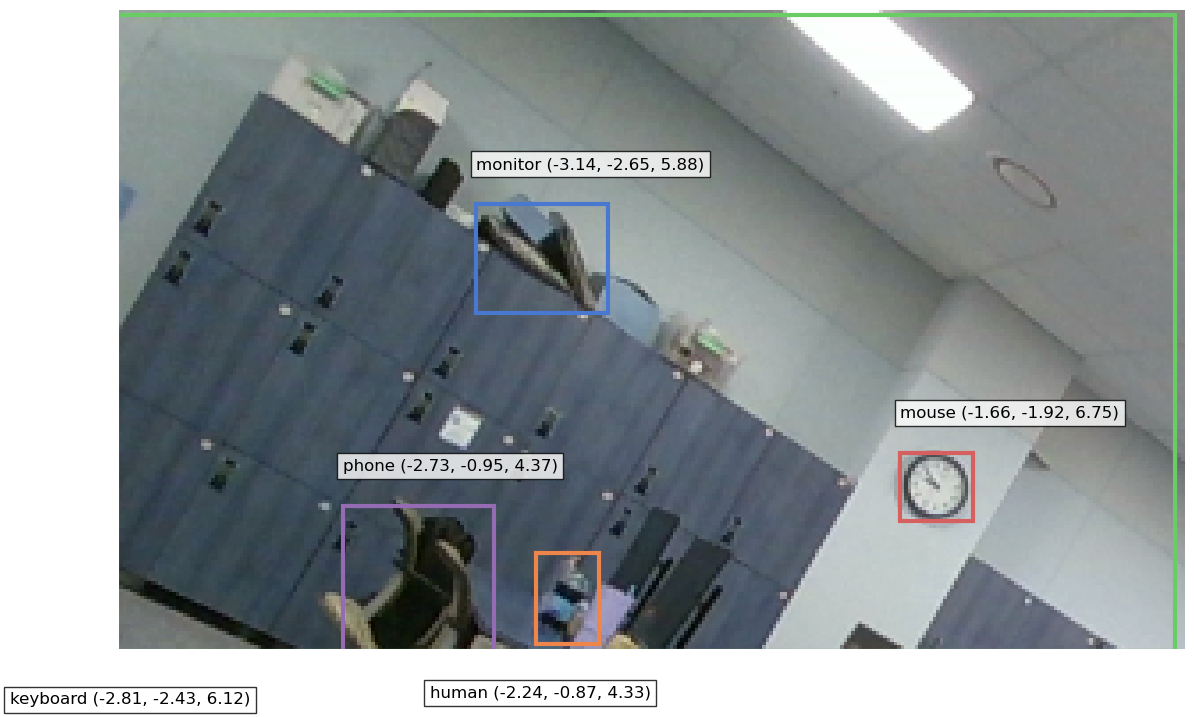

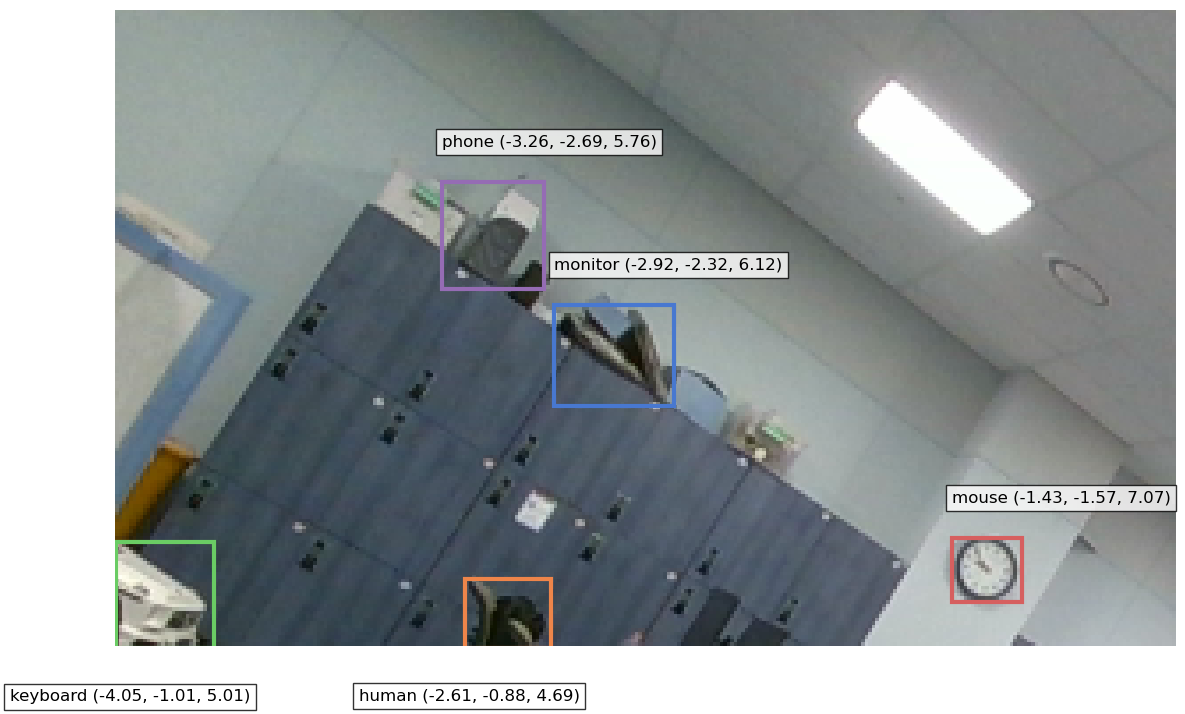

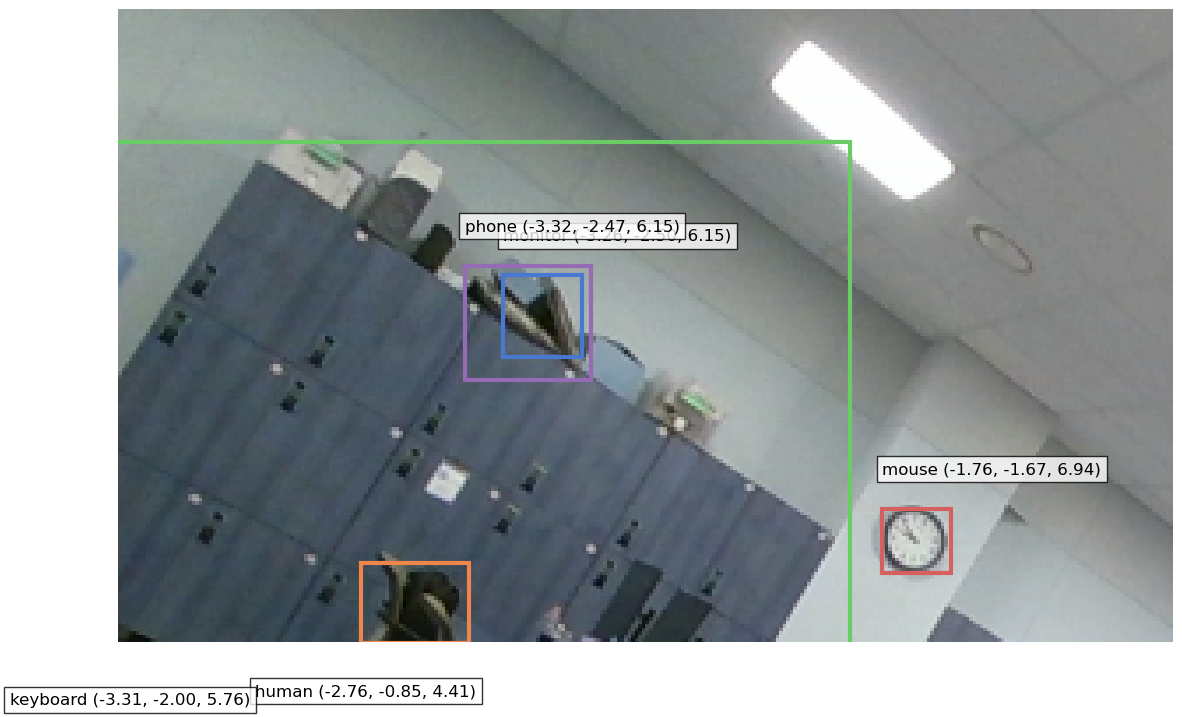

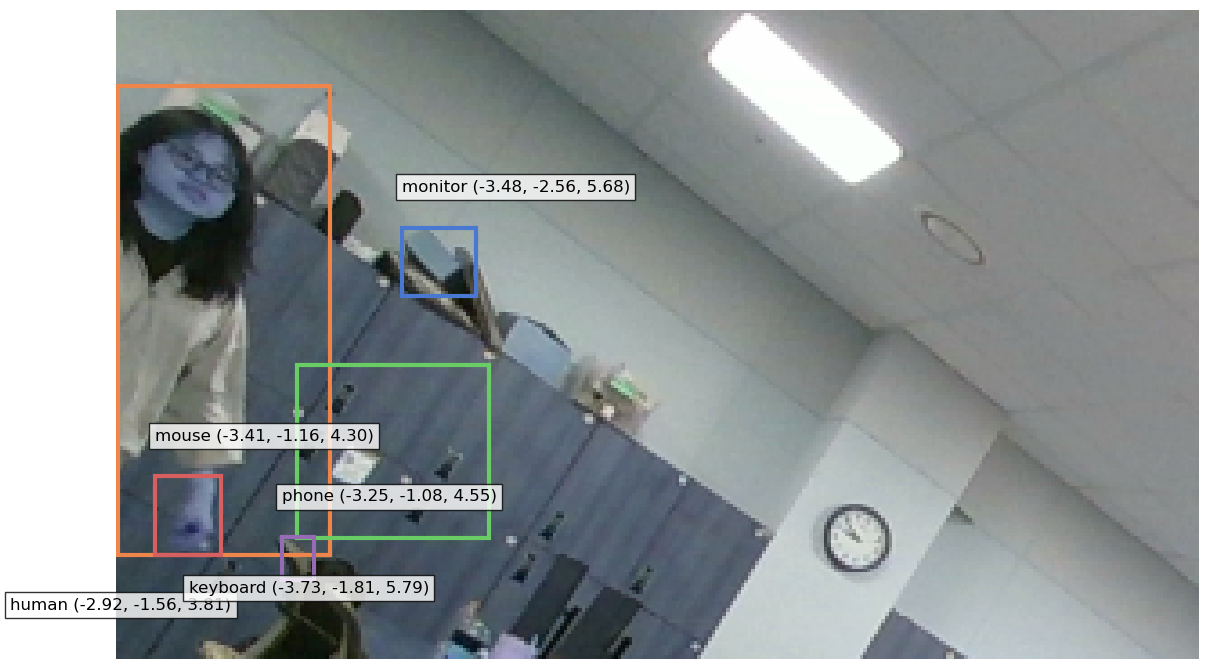

In [ ]:
#!/usr/bin/env python
# coding: utf-8

import os
import sys
import numpy as np
from copy import deepcopy
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import torch

from typing import Dict, List
from pydantic import dataclasses, validator

from generic import AllowArbitraryTypes

from transformers import OwlViTProcessor, OwlViTForObjectDetection
import pyrealsense2 as rs

WS_CROP_X = (0, 180)
WS_CROP_Y = (0, 300)

WORKSPACE_SURFACE = -0.025
BIN_TOP = 0.1
tool_orientation = [2.22, -2.22, 0.0]

@dataclasses.dataclass(config=AllowArbitraryTypes, frozen=True)
class EnvState:
    color_im: np.ndarray
    depth_im: np.ndarray
    objects: Dict[str, np.ndarray]

    @validator("color_im")
    @classmethod
    def color_im_shape(cls, v: np.ndarray):
        if v.shape[2] != 3:
            raise ValueError("color_im must have shape (H, W, 3)")
        return v
    
    @validator("depth_im")
    @classmethod
    def depth_im_shape(cls, v: np.ndarray, values):
        if v.shape != values["color_im"].shape[:2]:
            raise ValueError("color_im and depth_im must have same (H, W)")
        return v
    
    @validator("objects")
    @classmethod
    def objects_shape(cls, v: Dict[str, np.ndarray]):
        for obj in v:
            if v[obj].shape != (4,):
                raise ValueError("objects must have shape (4,)")
        return v

class RealSenseClient:
    def __init__(self):
        self.pipeline = rs.pipeline()
        self.config = rs.config()
        self.config.enable_stream(rs.stream.color, 640, 480, rs.format.bgr8, 30)
        self.config.enable_stream(rs.stream.depth, 640, 480, rs.format.z16, 30)
        self.pipeline.start(self.config)
    
    def get_camera_data(self):
        frames = self.pipeline.wait_for_frames()
        color_frame = frames.get_color_frame()
        depth_frame = frames.get_depth_frame()
        
        if not color_frame or not depth_frame:
            return None, None
        
        color_img = np.asanyarray(color_frame.get_data())
        depth_img = np.asanyarray(depth_frame.get_data())
        
        return color_img, depth_img

    def get_intrinsics(self):
        profile = self.pipeline.get_active_profile()
        intr = profile.get_stream(rs.stream.color).as_video_stream_profile().get_intrinsics()
        return np.array([[intr.fx, 0, intr.ppx],
                         [0, intr.fy, intr.ppy],
                         [0, 0, 1]])

class RealEnv():
    def __init__(
        self,
        bin_cam,
        task: str,
        all_objects: List[str],
        task_objects: List[str],
        output_name: str = None,
    ):
        self.bin_cam = bin_cam
        self.task = task
        self.all_objects = all_objects
        self.task_objects = task_objects
        if output_name is None:
            self.output_name = f"real_world/outputs/{self.task}/"
        else:
            self.output_name = f"real_world/outputs/{output_name}/"
        os.makedirs(self.output_name, exist_ok=True)

        self.robot_name = 'Bob'
        self.human_name = 'Alice'

        self.model = OwlViTForObjectDetection.from_pretrained("google/owlvit-base-patch32")
        self.processor = OwlViTProcessor.from_pretrained("google/owlvit-base-patch32")

        self.timestep = 0
    
    def get_obs(self, save=False) -> EnvState:
        color_im, depth_im = self.bin_cam.get_camera_data()
        ws_color_im = color_im[WS_CROP_X[0]:WS_CROP_X[1], WS_CROP_Y[0]:WS_CROP_Y[1]]
        ws_depth_im = depth_im[WS_CROP_X[0]:WS_CROP_X[1], WS_CROP_Y[0]:WS_CROP_Y[1]]

        image = Image.fromarray(ws_color_im)
        text = self.all_objects

        inputs = self.processor(text=[text], images=image, return_tensors="pt")
        outputs = self.model(**inputs)
        target_sizes = torch.Tensor([image.size[::-1]])
        results = self.processor.post_process(outputs=outputs, target_sizes=target_sizes)
        pred_scores = results[0]["scores"].detach().numpy()
        pred_labels, pred_boxes = results[0]["labels"].detach().numpy(), results[0]["boxes"].detach().numpy()

        objects = {}
        for label in np.unique(pred_labels):
            max_score_idx = np.argmax(pred_scores[np.where(pred_labels == label)])
            max_box = pred_boxes[np.where(pred_labels == label)][max_score_idx]
            objects[text[label]] = max_box
        
        self.timestep += 1
        if save:
            image.save(f"{self.output_name}/img_{self.timestep}.png")
        obs = EnvState(
            color_im=color_im,
            depth_im=depth_im,
            objects=objects,
        )
        return obs

    def get_3d_coordinates(self, x, y, depth_im, intrinsics):
        depth_scale = 0.001  # RealSense depth scale
        z = depth_im[y, x] * depth_scale
        x = (x - intrinsics[0, 2]) * z / intrinsics[0, 0]
        y = (y - intrinsics[1, 2]) * z / intrinsics[1, 1]
        return x, y, z
        
    def plot_preds(self, color_im, depth_im, objects, intrinsics, save=True, show=True):
        fig, ax = plt.subplots(figsize=(12, 12 * color_im.shape[0] / color_im.shape[1]))
        ax.imshow(color_im)
        colors = sns.color_palette('muted', len(objects))
        for label, c in zip(objects, colors):
            (xmin, ymin, xmax, ymax) = objects[label]
            x_center = int((xmin + xmax) / 2)
            y_center = int((ymin + ymax) / 2)
            x, y, z = self.get_3d_coordinates(x_center, y_center, depth_im, intrinsics)
            ax.add_patch(
                plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, color=c, linewidth=3))
            label_text = f"{label} ({x:.2f}, {y:.2f}, {z:.2f})"
            if label in self.task_objects:
                ax.text(xmin-30, ymax+15, label_text, fontsize=12, bbox=dict(facecolor='white', alpha=0.8))
            else:
                ax.text(xmin, ymin-10, label_text, fontsize=12, bbox=dict(facecolor='white', alpha=0.8))
        plt.axis('off')
        fig.tight_layout()

        if show:
            plt.show()
        if save:
            fig.savefig(f"{self.output_name}/pred_{self.timestep}.png")
        
    def describe_task_context(self):
        raise NotImplementedError
    
    def chat_mode_prompt(self):
        raise NotImplementedError

    def get_action_prompt(self):
        raise NotImplementedError
    
    def get_system_prompt(
        self, 
        mode="chat", 
        obs = None, 
        chat_history: List[Dict] = [], 
        feedback_history: List[str] = [],
        include_comm_prompt=True,
    ):
        context = self.describe_task_context()
        
        if mode == "chat":
            comm_prompt = self.chat_mode_prompt()
        else:
            raise NotImplementedError
        
        history = ''
        round_num = len(chat_history)
        if len(chat_history) > 0:
            history = f"[History]\n"
            for i, response in enumerate(chat_history):
                history += f"=== Round #{i}: === \n{response}\n"
        
        scene_desp = f"=== Round {round_num}: === \n" + (self.describe_scene(obs.objects) if obs is not None else "")
        feedback_history = "\n".join(feedback_history)
        if not include_comm_prompt:
            system_prompt = f"{context}\n{history}\n{scene_desp}\n{feedback_history}"
        else:
            system_prompt = f"{context}\n{history}\n{scene_desp}\n{feedback_history}\n{comm_prompt}"
        breakdown = dict(
            task_context=context,
            comm_prompt=comm_prompt,
            scene_desp=scene_desp,
            feedback_history=feedback_history,
        )
        return system_prompt, breakdown
    
    def pick_and_place_primitive(self, obs, pick_obj, place_where):
        if pick_obj not in obs.objects:
            raise Exception(f"PICK: {pick_obj} not detected")
        if place_where not in obs.objects:
            raise Exception(f"PLACE: {place_where} not detected")

        pick_pix = [int((obs.objects[pick_obj][0] + obs.objects[pick_obj][2])/2), int((obs.objects[pick_obj][1] + obs.objects[pick_obj][3])/2)]
        pick_pix = pick_pix[0] + WS_CROP_Y[0], pick_pix[1] + WS_CROP_X[0]

        place_pix = [int((obs.objects[place_where][0] + obs.objects[place_where][2])/2), int((obs.objects[place_where][1] + obs.objects[place_where][3])/2)]
        place_pix = place_pix[0] + WS_CROP_Y[0] + 20, place_pix[1] + WS_CROP_X[0]

        bin_cam_pose = np.loadtxt('real_world/cam_pose/cam2ur_pose.txt')
        bin_cam_depth_scale = 0.001 # RealSense depth scale is typically 0.001

        z = obs.depth_im[pick_pix[1], pick_pix[0]] * bin_cam_depth_scale
        x = (pick_pix[0]-self.bin_cam.color_intr[0, 2]) * z/self.bin_cam.color_intr[0, 0]
        y = (pick_pix[1]-self.bin_cam.color_intr[1, 2]) * z/self.bin_cam.color_intr[1, 1]
        if z == 0:
            return
        pick_point = np.asarray([x, y, z])
        pick_point = np.append(pick_point, 1.0).reshape(4, 1)

        pick_pos = np.dot(bin_cam_pose, pick_point)
        pick_pos = pick_pos[0:3, 0]
        pick_pos[2] = max(pick_pos[2], WORKSPACE_SURFACE)

        self.robot.open_suction_sys()
        if self.robot.check_grasp() == False:
            self.robot.open_gripper()
            print("Moving robot to target position for pick...")
            postpick_pos = deepcopy(pick_pos)
            postpick_pos[2] += 0.2
            self.robot.movel(list(pick_pos) + tool_orientation, 0.5, 0.1, blocking=True)
            self.robot.close_gripper()
            while not self.robot.check_grasp():
                pick_pos[2] -= 0.01
                if pick_pos[2] < WORKSPACE_SURFACE:
                    print("Reached workspace surface; cannot go lower")
                    self.robot.open_gripper()
                    break
                self.robot.movel(list(pick_pos) + tool_orientation, 0.05, 0.05, blocking=True)
            self.robot.movel(list(postpick_pos) + tool_orientation, 0.5, 0.1, blocking=True)

        z = obs.depth_im[place_pix[1], place_pix[0]] * bin_cam_depth_scale
        x = (place_pix[0]-self.bin_cam.color_intr[0, 2]) * z/self.bin_cam.color_intr[0, 0]
        y = (place_pix[1]-self.bin_cam.color_intr[1, 2]) * z/self.bin_cam.color_intr[1, 1]
        if z == 0:
            return
        place_point = np.asarray([x, y, z])
        place_point = np.append(place_point, 1.0).reshape(4, 1)

        place_pos = np.dot(bin_cam_pose, place_point)
        place_pos = place_pos[0:3, 0]
        place_pos[2] = max(place_pos[2], BIN_TOP)
        if self.robot.check_grasp() == True:
            print("Moving robot to target position for place...")
            prepostplace_pos = deepcopy(place_pos)
            prepostplace_pos[2] += 0.1
            self.robot.movel(list(prepostplace_pos) + tool_orientation, 0.5, 0.1, blocking=True)
            self.robot.movel(list(place_pos) + tool_orientation, 0.5, 0.1, blocking=True)
            self.robot.open_gripper()
            self.robot.movel(list(prepostplace_pos) + tool_orientation, 0.5, 0.1, blocking=True)
        self.robot.close_suction_sys()
        self.robot.home()

def main():
    bin_cam = RealSenseClient()
    env = RealEnv(
        bin_cam=bin_cam,
        task='block_in_cup',
        all_objects=["monitor", "human", "keyboard", "mouse", "phone"],
        task_objects=["human", "keyboard"])

    intrinsics = bin_cam.get_intrinsics()

    try:
        while True:
            obs = env.get_obs(True)
            ws_color_im = obs.color_im[WS_CROP_X[0]:WS_CROP_X[1], WS_CROP_Y[0]:WS_CROP_Y[1]]
            ws_depth_im = obs.depth_im[WS_CROP_X[0]:WS_CROP_X[1], WS_CROP_Y[0]:WS_CROP_Y[1]]
            env.plot_preds(ws_color_im, ws_depth_im, obs.objects, intrinsics, save=True, show=True)
    except KeyboardInterrupt:
        print("Detection loop stopped.")

if __name__ == "__main__":
    main()
